# TMDB Rating Prediction Based on Several Factors (Emanuel Azcona)

Is it possible to predict a movie's critic success before it is even released? Are there key/certain cast members (actors/actresses) or essential crew (directors, producers, etc.) that contribute to the critical success of a movie? In this project we investigate and create a an appropiate regression model for predicting a movie's IMDB critic rating based on different attributes like: cast, crew, and more.

In this project, critic rating is given to us in the form of a non-integer score between $0$ and $10$.

## Dataset (TMDB)

The dataset was obtained from Kaggle under: https://www.kaggle.com/tmdb/tmdb-movie-metadata. Per a DMCA takedown request from IMDB, the original IMDB dataset was removed. In order to minimize the impact, Kaggle replaced the dataset with the TMDB dataset, which consists of a similar set of films and data fields in accordance with their terms of use (https://www.themoviedb.org/documentation/api/terms-of-use).

The dataset itself contains two .$\texttt{CSV}$ files:
- $\texttt{tmdb}\text{_}\texttt{5000}\text{_}\texttt{credits.csv}$
- $\texttt{tmdb}\text{_}\texttt{5000}\text{_}\texttt{movies.csv}$

where the "credits" file contains crediting information about the 5000 movies in the datset (title, cast, crew) and the "movies" file contains the following information about each movie:
- budget
- voter rating
- voter count (number of people who voted)
- revenue
- genre(s)
- homepage
- keywords
- original language
- original title
- and way more.

For the purposes of this experiment, we're only going to focus on using the entire "credits" file and the budget/revenue columns of the "movies" file.

### Loading Credits & Movies Files

For data manipulation throughout this experiment, we're going to rely on the Pandas library (available through $\texttt{pip}$ or $\texttt{conda}$).

In [1]:
import pandas as pd # typical naming convention for abbreviating [pandas]
import ast          # I only use this library to convert strings into their literal Python interpretations
import numpy as np  # using the original NumPy library, not the autograd one (since I'm using Keras)

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load in dataset using pandas
creditsDF = pd.read_csv('tmdb_5000_credits.csv')
moviesDF = pd.read_csv('tmdb_5000_movies.csv')

# sanity check (compare number of samples in each .CSV file)
print('There are ' + str( creditsDF.shape[0] ) + ' movies in the "credits" file.')
print('There are ' + str( moviesDF.shape[0] ) + ' movies in the "movies" file.')

There are 4803 movies in the "credits" file.
There are 4803 movies in the "movies" file.


In [3]:
# I wrote this as a sanity-check to see if every row in each .CSV file corresponds
# to the respective row in the other.
mistakeInData = False
for i in range( creditsDF.shape[0] ):
    if creditsDF['movie_id'][i] != moviesDF['id'][i]:
        mistakeInData = True
if mistakeInData:
    print('\nSomething is up dude. Double-check the data.')
else:
    print('\nDataset is legitimate. Proceed.')
    
# Overview of the first few samples for the movies dataframe
moviesDF.head()


Dataset is legitimate. Proceed.


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
# Overview of the first few samples for the credits dataframe
creditsDF.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Cleaning and Manipulating Data to Create Clean Dictionaries of Movie Information

It's a little annoying to be manipulating two seperate dataframes related to one set of data. For that reason, a single dictionary is created to avoid confusion across datasets. The dictionary data structure was chosen because of its constant, $O(1)$, indexing runtime (I read some forums and documentation warning that Pandas indexing may not run, $O(1)$).

In the process of creating the dictionary, we must be careful to only extract and store information that is relevant and/or may be helpful to determining critic rating. One example of information that may not be helpful that is not included is the homepage to a particular movie.

Throughout the function below, I detail which features I decide to store during each iteration while parsing through the movie dataset.

I also made the decision to remove any movie in the dataset that has less voter counts than the overall median voter count. Why did I decide upon this median metric? I can not give a reasonable answer to that other than, it seemed reasonable. The motivation behind this is credited to some of the movies having unreasonably high ($10$) or low ($0$) ratings with only $1$ or $0$ voters.

In [5]:
def createMovieDictionary(creditsDF, moviesDF):
    
    # initialize dictionary of movies
    movies = {}
    
    # initiailize corresponding set of keys for the movies dictionary
    # I use a set to make sure that no movie has duplicate keys
    keys = set()
    
    # go through every movie in the dataset O(N)
    for i in range(moviesDF.shape[0]):
        
        budget = moviesDF['budget'][i]          # temporarily store the budget for the current movie
        allVoteCounts = moviesDF['vote_count']  # temporarily store vote count for current movie
        medVoteCount = np.median(allVoteCounts) # determine median of the vote counts
        
        # check to see if we're dealing with a non-zero budget movie
        if budget > 0:
            
            # only continue if the current number of votes is bigger than the median
            if allVoteCounts[i] >= medVoteCount:
                
                cast = ast.literal_eval( creditsDF['cast'][i] ) # temporarily extract cast and create a list
                cast = set( [member['name'] for member in cast if member['order'] <= 2] )

                crew = ast.literal_eval( creditsDF['crew'][i] ) # repeat the cast process for the crew members as well
                crew = set( [member['name'] for member in crew if member['job'] == 'Director' or member['job'] == 'Producer'] )
                
                genres = ast.literal_eval( moviesDF['genres'][i] ) # repeat for genres
                genres = set( [g['name'] for g in genres] )
                
                production_companies = ast.literal_eval( moviesDF['production_companies'][i] ) # repeat for production companies
                production_companies = set( [p['name'] for p in production_companies] )
                
                
                # temporarily save movie ID of the movie from id column of current film
                movID = moviesDF['id'][i]

                # temporarily save title of current movie
                title = moviesDF['title'][i]
                
                # temporarily save the rating of the current movie
                rating = moviesDF['vote_average'][i]
                
                # append the set of keys with the current movie's ID
                keys.update({movID})
                
                movies[movID] = {'title': title}              # first entry of the current dictionary is the title
                movies[movID]['cast'] = cast                  # assign set of cast members
                movies[movID]['crew'] = crew                  # assign set of crew members
                movies[movID]['budget'] = budget              # assign budget
                movies[movID]['rate'] = rating                # assign rating
                movies[movID]['genres'] = genres              # assign genres
                movies[movID]['prod'] = production_companies  # assign production companies

    return movies, keys

In [6]:
movies, keys = createMovieDictionary(creditsDF,moviesDF)

# I'm paranoid, so I'm just deleting these dataframes now to free up some space
del moviesDF, creditsDF

# Another sanity check
print("The movie dictionary has: " + str(len(movies)) + " entries." )

The movie dictionary has: 2302 entries.


### Determine Distinct Items Pertaining to Features That Are Sets/Lists

Next, a function was created to create individual sets of the distinct cast, crew, genres, and production companies in the movies we extracted. We can utilize the Python $\texttt{set}(\cdot)$ method that creates a distinct set data structure for eliminating repeat cast or crew members.

In [7]:
def distinctThings(movies, key):
    
    # only return a set if the key entered is cast, crew, genres, or production companies
    if key in ['cast', 'crew', 'genres', 'prod']:
        
        distinct = set() # create distinction set
        
        for m in movies:                # iterate through all the movies in the dictionary
            for member in movies[m][key]: # iterate through the list pertaining to the key
                distinct.update({member})
        return distinct
    else:
        return None

distinctCast = distinctThings(movies, 'cast')
distinctCrew = distinctThings(movies, 'crew')
distinctGenres = distinctThings(movies, 'genres')
distinctProd = distinctThings(movies, 'prod')

# Create Rating Regression Model Based Only on Budget

### Simple 1-D Feature & 1-D Predictor Regression Model (Rating Based on Budget)

Time to play around with the data! To start things off, we can first create a simple regression model using a very minimal deep-feedforward network in Keras.

Before doing anything, two functions were created, createFeatures() and createPredictors(), that let us create feature/predictor matrices using NumPy. Keras by default takes in NumPy arrays as data inputs.

In [8]:
N_samples = len(movies)

def createFeatures(feature):
    
    abort = False
    # if we're only using the budget, we'll have a single column for X
    if feature is 'budget':
        N_features = 1
    
    # otherwise N_features is # of distinct possible cast, crew, etc.
    elif feature is 'cast':              
        N_features = len(distinctCast)
    elif feature is 'crew':
        N_features = len(distinctCrew)
    elif feature is 'genres':
        N_features = len(distinctGenres)
    elif feature is 'prod':
        N_features = len(distinctProd)
    else:
        abort = True
    
    # if the number of features is still 0, then obviously we didn't input 1 of the above ^
    if abort:
        return None, None
    else:
        # initialize  data array to array of zeros
        # in the case of the feature being anything else besides budget, we will have a mostly sparse array
        X = np.zeros( (N_samples, N_features) )

        # iterate over keys set we created earlier (so we can iterate through the movies)
        # "i" in this case will be the corresponding row to a movie (starting at 0)
        for i, ID in enumerate(keys):
            currentMovie = movies[ID]
            
            # budget results in a 1-dimensional feature fector
            if feature is 'budget':
                X[i, 0] = currentMovie[feature]
            
            # all other features result in NxM feature matrices (very sparse for all)
            else:
                if feature is 'cast':
                    for j, member in enumerate(distinctCast):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                elif feature is 'crew':
                    for j, member in enumerate(distinctCrew):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                elif feature is 'genres':
                    for j, member in enumerate(distinctGenres):
                        if member in currentMovie[feature]:
                            X[i,j] = 1
                
                else:
                    for j, member in enumerate(distinctProd):
                        if member in currentMovie[feature]:
                            X[i,j] = 1

        return X

# short function for creating 1-dimensional predictor vector 
def createPredictors():
    y = np.zeros((N_samples,1))
    for i, ID in enumerate(keys):
        currentMovie = movies[ID]
        
        y[i,0] = currentMovie['rate']
    return y

In [9]:
X = createFeatures('budget')
y = createPredictors()

# sanity check
print(X.shape, y.shape)

((2302, 1), (2302, 1))


### Normalize Input Data (Optimization Trick to Reduce # of Epochs Required for Training)

Here, we utilize an optimization trick (normalizing the input data) that helps in reducing the number of epochs required for training. There are many methods for normalizing a vector. A common one being:

\begin{equation}
    \vec{x}_{norm} = \frac{\vec{x} - \mu_x}{\sigma_x}
\end{equation}

In this project, we use the Scikit-learn library which provides a normalization function that uses the $\mathcal{l}_2$ norm for normalization.

\begin{equation}
    \vec{x}_{norm} = \frac{\vec{x}}{\|\vec{x}\|_2}
\end{equation}

In [10]:
from sklearn.preprocessing import normalize

Xnorm = normalize(X, axis = 0, norm = 'l2')

### Using Keras (Tensorflow Backend)

Keras is a high-level neural network API, for Python, for use on top of Tensorflow, CNTK, or Theano. Since Theano updates will soon stop, and Tensorflow (although slow for the time being) is Google-backed and owned I used Keras with a Tensorflow backend.

Rather than viewing the losses throughout training, a Keras callback was defined below to store loss history.

In [11]:
import keras

# self-defined keras callback for saving a history of losses per epoch during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append([logs.get('loss'), logs.get('val_loss')])

Using TensorFlow backend.


In [12]:
from keras.models import Sequential          # Very simple sequential layer model making in Keras
from keras.layers import Dense               # Simple fully-connected feed-forward layers in Keras
from sklearn.model_selection import KFold    # Sci-kit learn functions for dividing data into testing/training sets using indices

seed = 7  # random number generator seed value (all cases will use 7 from here on out)
folds = 4 # 3/4 training - 1/4 testing split

# create instance of weight intializer for keras layers using seed
initialWeights = keras.initializers.RandomNormal(mean=0.0, stddev=0.07, seed=seed)

# create folding object using same seed and fold #
kfold = KFold(n_splits=folds, shuffle=True, random_state=seed)

num_epochs = 20

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=64, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=32, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/20
1726/1726 [==============================] - 0s - loss: 6.4104 - val_loss: 6.3257
Epoch 2/20
1726/1726 [==============================] - 0s - loss: 6.0205 - val_loss: 5.4311
Epoch 3/20
1726/1726 [==============================] - 0s - loss: 3.8390 - val_loss: 1.1797
Epoch 4/20
1726/1726 [==============================] - 0s - loss: 0.8005 - val_loss: 0.7136
Epoch 5/20
1726/1726 [==============================] - 0s - loss: 0.6752 - val_loss: 0.6463
Epoch 6/20
1726/1726 [==============================] - 0s - loss: 0.6606 - val_loss: 0.6445
Epoch 7/20
1726/1726 [==============================] - 0s - loss: 0.6587 - val_loss: 0.6438
Epoch 8/20
1726/1726 [==============================] - 0s - loss: 0.6594 - val_loss: 0.6422
Epoch 9/20
1726/1726 [==============================] - 0s - loss: 0.6564 - val_loss: 0.6425
Epoch 10/20
1726/1726 [==============================] - 0s - loss: 0.6579 - val_loss: 0.6405
Epoch 11/20
1726/1726 

### Plotting Training and Validation Loss History

To save time for future parts, I created a function that plots the training and validation loss history throughout training for our models. The average training and validation loss were also plotted.

In [13]:
import matplotlib.gridspec as gridspec

def plotCrossValScores(scores, folds, epochs):
    
    trainingLossHistory = scores[:].T[0].T
    validationLossHistory = scores[:].T[1].T

    meanTrainingLossHistory = np.mean(trainingLossHistory, axis = 0)
    meanValidationLossHistory = np.mean(validationLossHistory, axis = 0)
    
    gs = gridspec.GridSpec(folds+1, 2) # create two seperate columns for the training / validation loss
    f = plt.figure(figsize= (40, 30))  # construct figure with set size
    
    # loop through the number of folds
    for i in range(folds):
        
        # training loss column
        curr = f.add_subplot(gs[i,0])
        curr.plot(trainingLossHistory[i], 'o', markersize = 13)
        curr.set_ylabel('Fold-' + str(i+1), fontsize = 27)
        curr.tick_params(labelsize = 18)
        curr.grid()
        if i is 0:
            curr.set_title('Training Loss', fontsize = 35)
        elif i is folds-1:
            curr.set_xlabel('Epochs', fontsize = 27)
        
        # validation loss column
        curr = f.add_subplot(gs[i,1])
        curr.plot(validationLossHistory[i],'o', markersize = 13)
        curr.set_ylabel('Fold-' + str(i+1), fontsize = 27)
        curr.tick_params(labelsize = 18)
        curr.grid()
        if i is 0:
            curr.set_title('Validation Loss', fontsize = 35)
        elif i is folds-1:
            curr.set_xlabel('Epochs', fontsize = 27)
    
    # mean training/validation loss plot (spans both columns)
    curr = f.add_subplot(gs[-1,:])
    curr.set_title('Mean Training/Validation Loss', fontsize = 30)
    curr.plot(meanTrainingLossHistory, 'o', label = 'Avg. Training Loss', markersize = 13)
    curr.plot(meanValidationLossHistory, 'o', label = 'Avg. Validation Loss', markersize = 13)
    curr.tick_params(labelsize = 18)
    curr.legend(fontsize = 27)
    curr.set_xlabel('Epoch', fontsize = 27)
    curr.set_ylabel('Mean Absolute Error Cost', fontsize = 27)
    curr.grid(True)
    plt.show()
    
    return meanTrainingLossHistory, meanValidationLossHistory

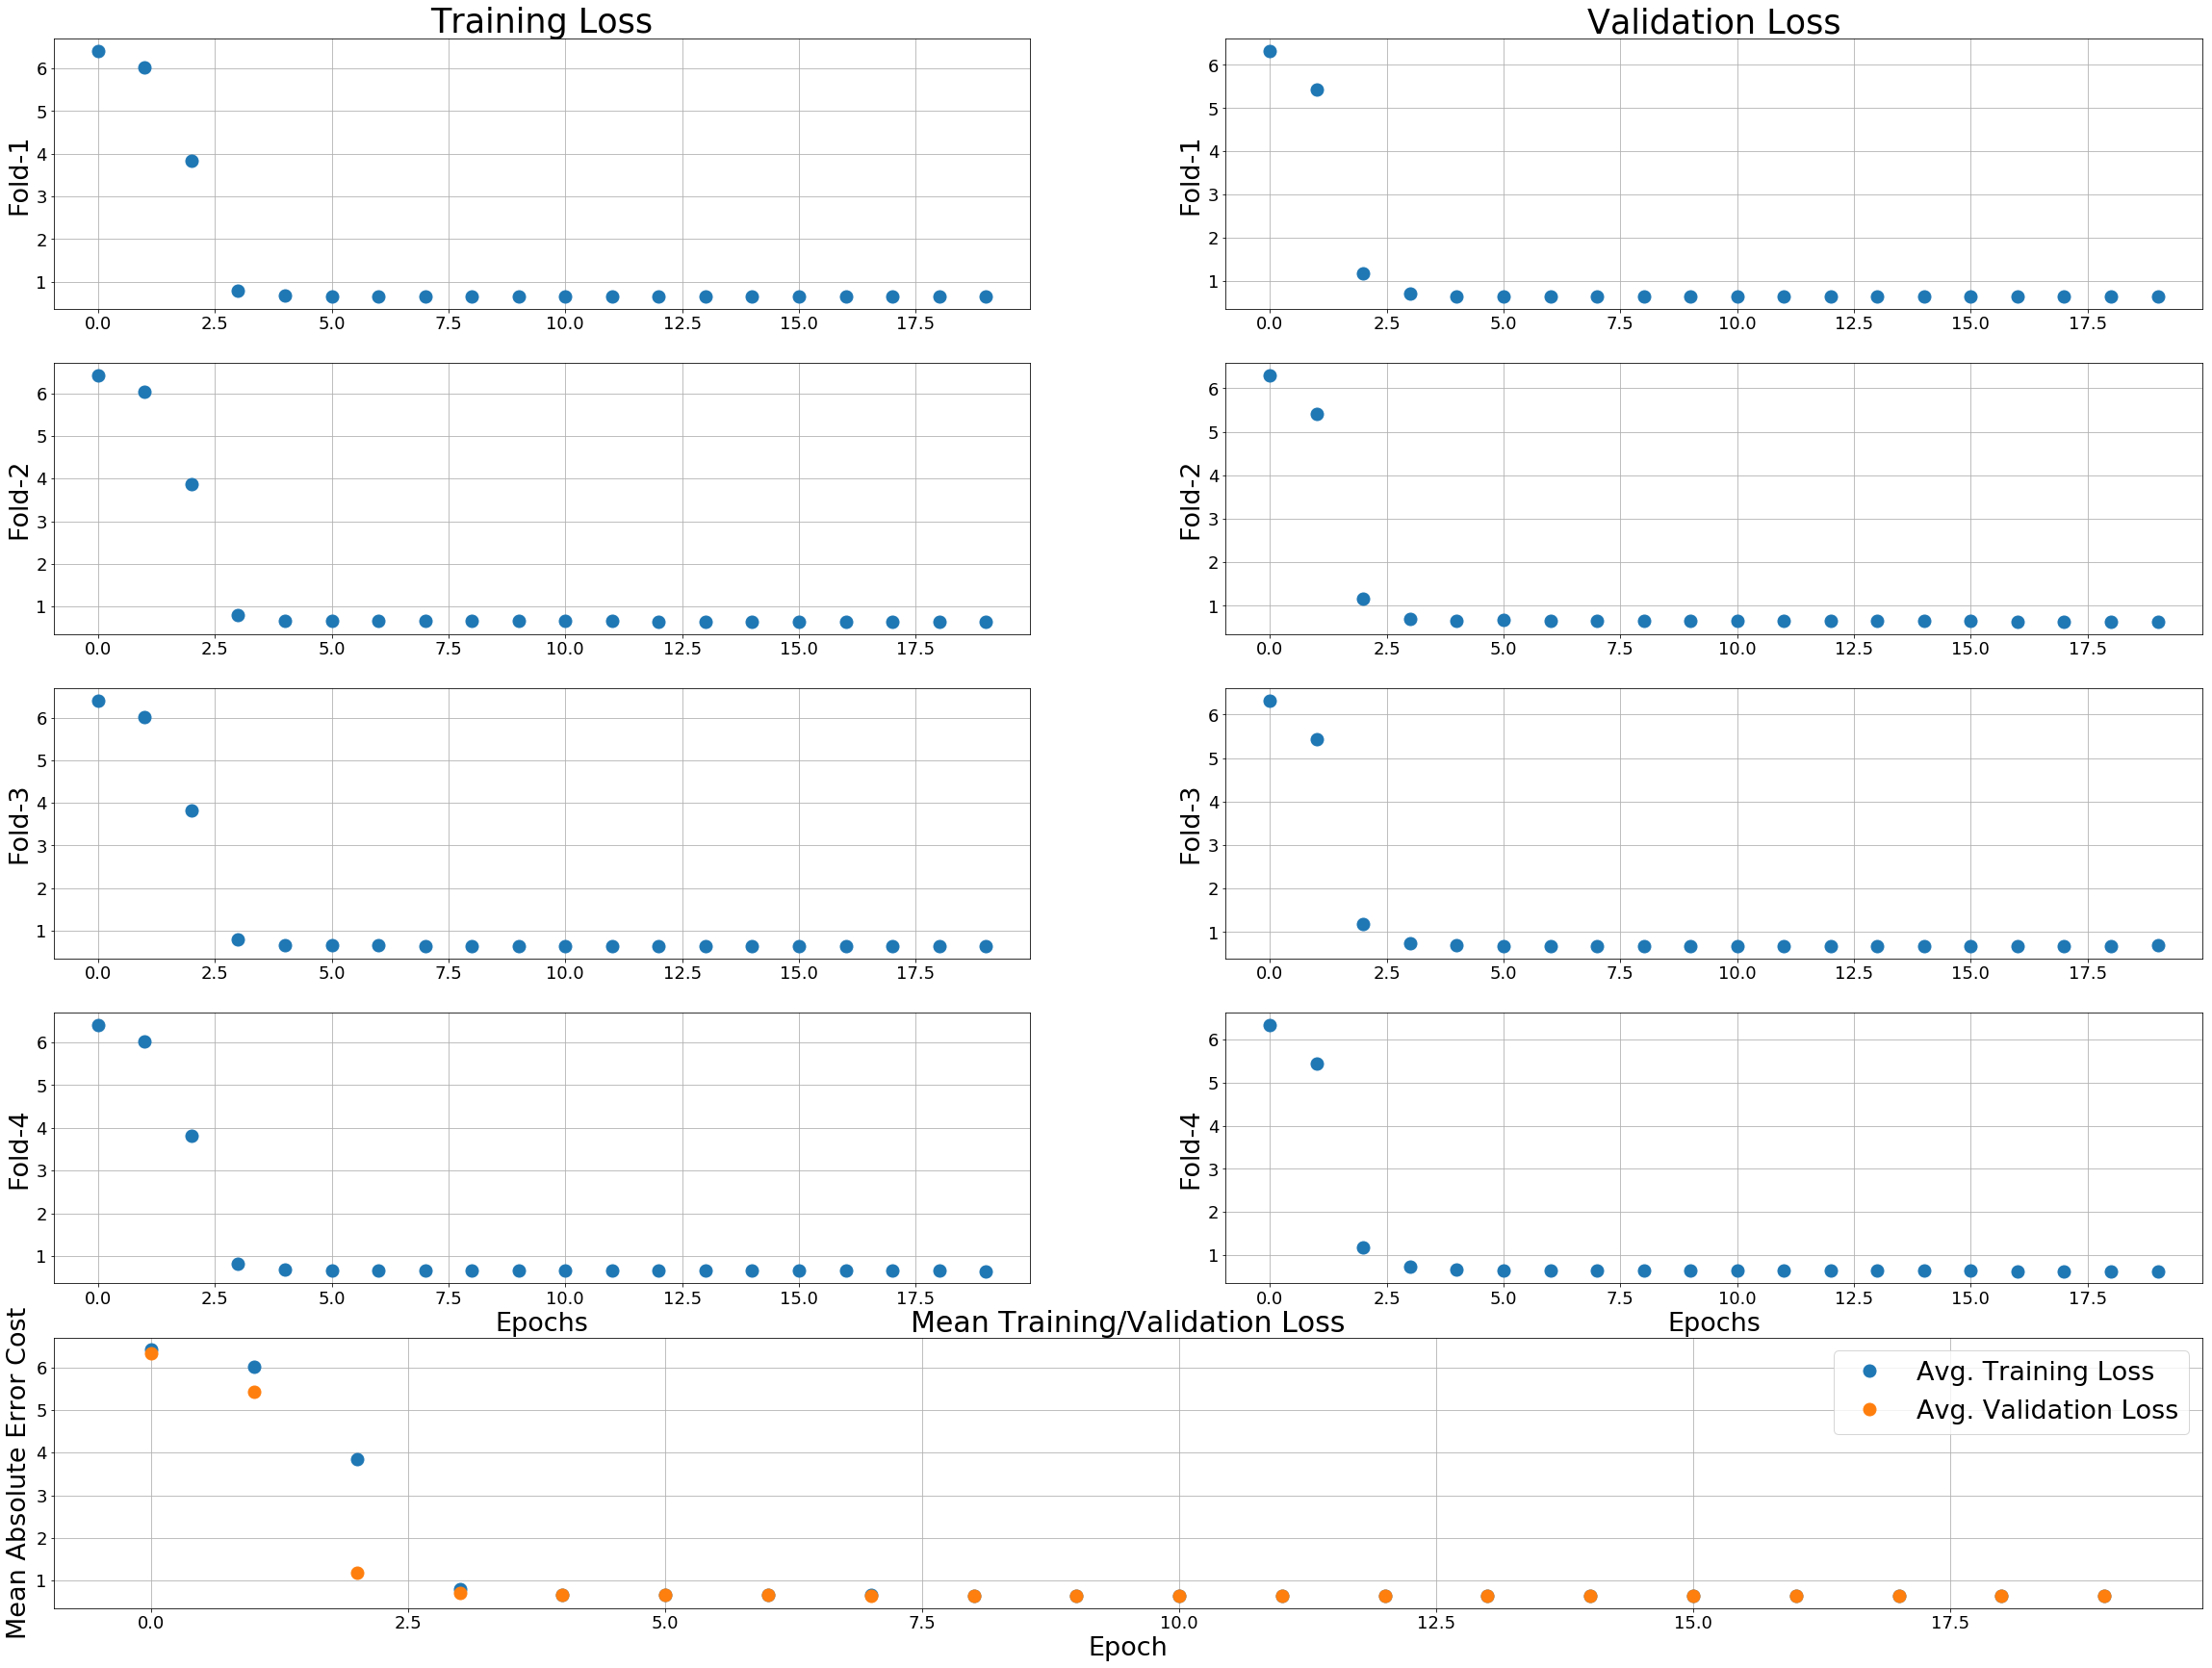

In [14]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

### This Is Good News!

This is great! It seems that the validation loss and training loss are at a pass and stay constant after about 10 epochs of stochastic gradient descent. Since we decided to use the mean absolute error cost function, it is easy to see that after 10 epochs of training we our average error across when using budgets to predict ratings is off by $\approx \pm 0.6$. This error rate is on a scale with ratings that range between 0 and 10.

One very useful metric to determine is which set of weights for our network were the "most useful." One way to determine this is to sort the validation and training losses  in lexicographical order.

Luckily, the NumPy library provides a function, lexsort(), that does lexicographical sorting and returns the indices of the order for the elements. In other words, we sort our loss data, first by order from smallest to largest validation loss, and then from smallest to largest training loss.

In [15]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[17 16 18 13 19 14 12 15 11 10  7  9  8  5  6  4  3  2  1  0]

Therefore, Epoch:17 would be a good place to stop training this model.


# REPEAT NOW: Create Rating Regression Model Based Only Top 3 Paid Cast Members

In [16]:
X = createFeatures('cast')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [17]:
num_epochs = 50

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/50
1726/1726 [==============================] - 0s - loss: 4.4518 - val_loss: 1.9037
Epoch 2/50
1726/1726 [==============================] - 0s - loss: 1.3668 - val_loss: 0.9867
Epoch 3/50
1726/1726 [==============================] - 0s - loss: 0.7709 - val_loss: 0.7823
Epoch 4/50
1726/1726 [==============================] - 0s - loss: 0.4812 - val_loss: 0.7372
Epoch 5/50
1726/1726 [==============================] - 0s - loss: 0.3727 - val_loss: 0.7405
Epoch 6/50
1726/1726 [==============================] - 0s - loss: 0.3186 - val_loss: 0.7383
Epoch 7/50
1726/1726 [==============================] - 0s - loss: 0.2894 - val_loss: 0.7531
Epoch 8/50
1726/1726 [==============================] - 0s - loss: 0.2826 - val_loss: 0.7407
Epoch 9/50
1726/1726 [==============================] - 0s - loss: 0.2702 - val_loss: 0.7479
Epoch 10/50
1726/1726 [==============================] - 0s - loss: 0.2593 - val_loss: 0.7273
Epoch 11/50
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.1692 - val_loss: 0.6801
Epoch 38/50
1726/1726 [==============================] - ETA: 0s - loss: 0.176 - 0s - loss: 0.1787 - val_loss: 0.6672
Epoch 39/50
1726/1726 [==============================] - 0s - loss: 0.1700 - val_loss: 0.6734
Epoch 40/50
1726/1726 [==============================] - 0s - loss: 0.1663 - val_loss: 0.6699
Epoch 41/50
1726/1726 [==============================] - 0s - loss: 0.1693 - val_loss: 0.6750
Epoch 42/50
1726/1726 [==============================] - 0s - loss: 0.1638 - val_loss: 0.6731
Epoch 43/50
1726/1726 [==============================] - 0s - loss: 0.1620 - val_loss: 0.6691
Epoch 44/50
1726/1726 [==============================] - 0s - loss: 0.1659 - val_loss: 0.6629
Epoch 45/50
1726/1726 [==============================] - 0s - loss: 0.1621 - val_loss: 0.6615
Epoch 46/50
1726/1726 [==============================] - 0s - loss: 0.1558 - val_loss: 0.6764
Epoch 47/50
1726/1726 [=========================

1727/1727 [==============================] - 0s - loss: 0.1912 - val_loss: 0.7441
Epoch 24/50
1727/1727 [==============================] - 0s - loss: 0.1838 - val_loss: 0.7433
Epoch 25/50
1727/1727 [==============================] - 0s - loss: 0.1968 - val_loss: 0.7371
Epoch 26/50
1727/1727 [==============================] - 0s - loss: 0.1943 - val_loss: 0.7465
Epoch 27/50
1727/1727 [==============================] - 0s - loss: 0.1796 - val_loss: 0.7352
Epoch 28/50
1727/1727 [==============================] - 0s - loss: 0.1769 - val_loss: 0.7439
Epoch 29/50
1727/1727 [==============================] - 0s - loss: 0.1784 - val_loss: 0.7448
Epoch 30/50
1727/1727 [==============================] - 0s - loss: 0.1712 - val_loss: 0.7400
Epoch 31/50
1727/1727 [==============================] - 0s - loss: 0.1818 - val_loss: 0.7403
Epoch 32/50
1727/1727 [==============================] - 0s - loss: 0.1717 - val_loss: 0.7482
Epoch 33/50
1727/1727 [==============================] - 0s - loss: 0.18

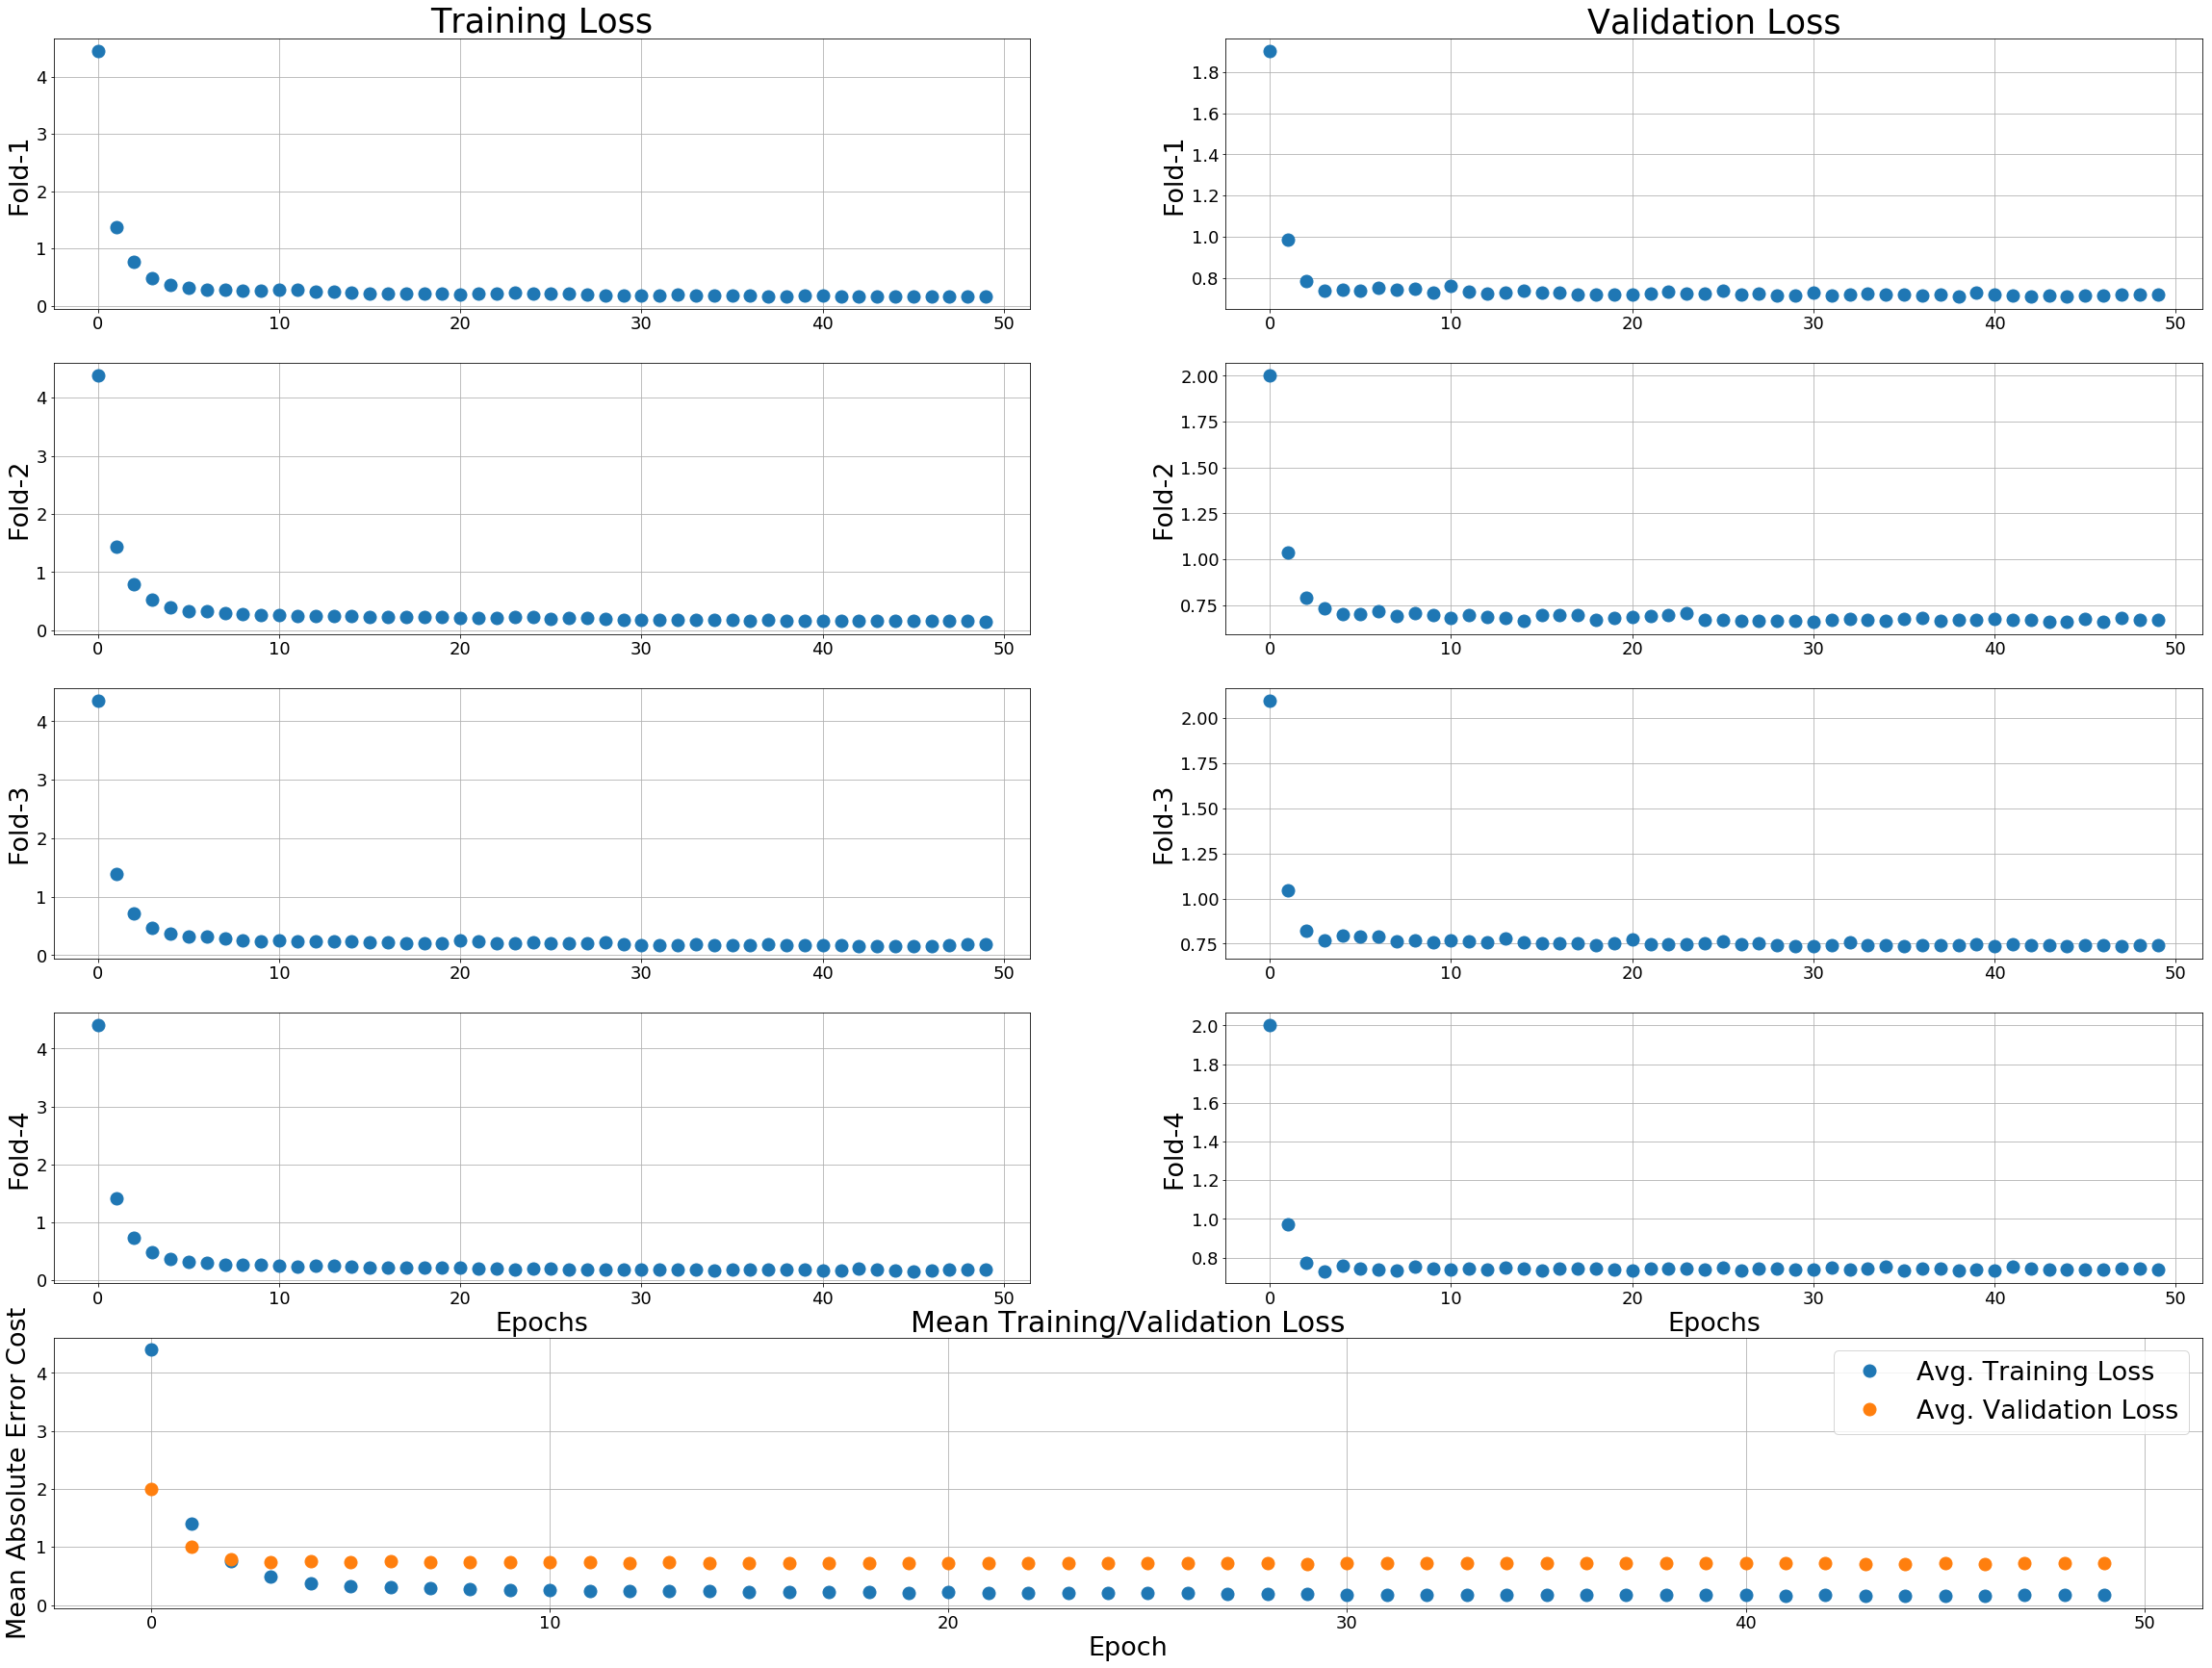

In [18]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [19]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[44 43 29 46 38 40 42 35 30 26 49 28 45 37 33 48 39 31 34 18 36 27 24 41 47
 19 32 12 14 21 17 15 20 25 16 22 23  9  7 11 13 10  5  3  8  4  6  2  1  0]

Therefore, Epoch:44 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we cast only 1 of our cast members per movie. In other words, we create 1 movie for every actor/actress in our "distinctCast" array, and in each movie we only cast the corresponding cast member.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view who the "top choices" would be to get the highest voter rating average.

In [20]:
Xset = []
for i in range(0, len(distinctCast)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for castMember in Xset:
    predictions.append(float(model.predict(castMember)))

idx = np.argsort(predictions)

In [21]:
dList = list(distinctCast)

print('The best choices to make if you were to a cast only one "top-3" cast member would be:\n')
for i in idx[-1:-20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top-3" cast member would be:

Brad Pitt
Denzel Washington
Tom Hanks
Joe Pesci
Leonardo DiCaprio
Vin Diesel
Robert De Niro
Elijah Wood
Ralph Fiennes
Clint Eastwood
Ed Harris
Michael Caine
Robert Redford
Joaquin Phoenix
Kristen Wiig
Jared Leto
Alec Baldwin
Robert Downey Jr.
Marlon Brando


Given the state of the film industry today, the names that this model was able extrapolate are of various actors/actresses who have appeared in a lot of critically and commercially successful films, such as Brad Pitt, Tom Hanks, Leonardo Dicaprio, etc.

# REPEAT NOW: Create Rating Regression Model Based Only On Director & Producer

In [22]:
X = createFeatures('crew')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [23]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 0s - loss: 4.2955 - val_loss: 2.4112
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 1.7359 - val_loss: 1.2302
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 0.9348 - val_loss: 0.9688
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 0.5783 - val_loss: 0.9226
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 0.4351 - val_loss: 0.8422
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 0.3718 - val_loss: 0.8194
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 0.3340 - val_loss: 0.8101
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3108 - val_loss: 0.8236
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.2988 - val_loss: 0.8103
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.2794 - val_loss: 0.7707
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.3255 - val_loss: 0.8305
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3034 - val_loss: 0.8122
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.2923 - val_loss: 0.8016
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.2980 - val_loss: 0.7966
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.2733 - val_loss: 0.8127
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.2600 - val_loss: 0.7948
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.2480 - val_loss: 0.7748
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.2507 - val_loss: 0.7732
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.2460 - val_loss: 0.8045
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.2324 - val_loss: 0.7634
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.2257

1727/1727 [==============================] - 0s - loss: 0.2492 - val_loss: 0.8192
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.2611 - val_loss: 0.8687
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.2769 - val_loss: 0.8114
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.2583 - val_loss: 0.8396
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.2301 - val_loss: 0.7956
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.2261 - val_loss: 0.7972
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.2206 - val_loss: 0.7898
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2565 - val_loss: 0.8153
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2294 - val_loss: 0.7803
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2050 - val_loss: 0.7936
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.20

1727/1727 [==============================] - 0s - loss: 0.2241 - val_loss: 0.7375
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2283 - val_loss: 0.7262
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2150 - val_loss: 0.7174
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2206 - val_loss: 0.7274
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.2089 - val_loss: 0.7208
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.2092 - val_loss: 0.7179
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.1898 - val_loss: 0.7208
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.2018 - val_loss: 0.6990
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.1893 - val_loss: 0.7042
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.2007 - val_loss: 0.6885
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.19

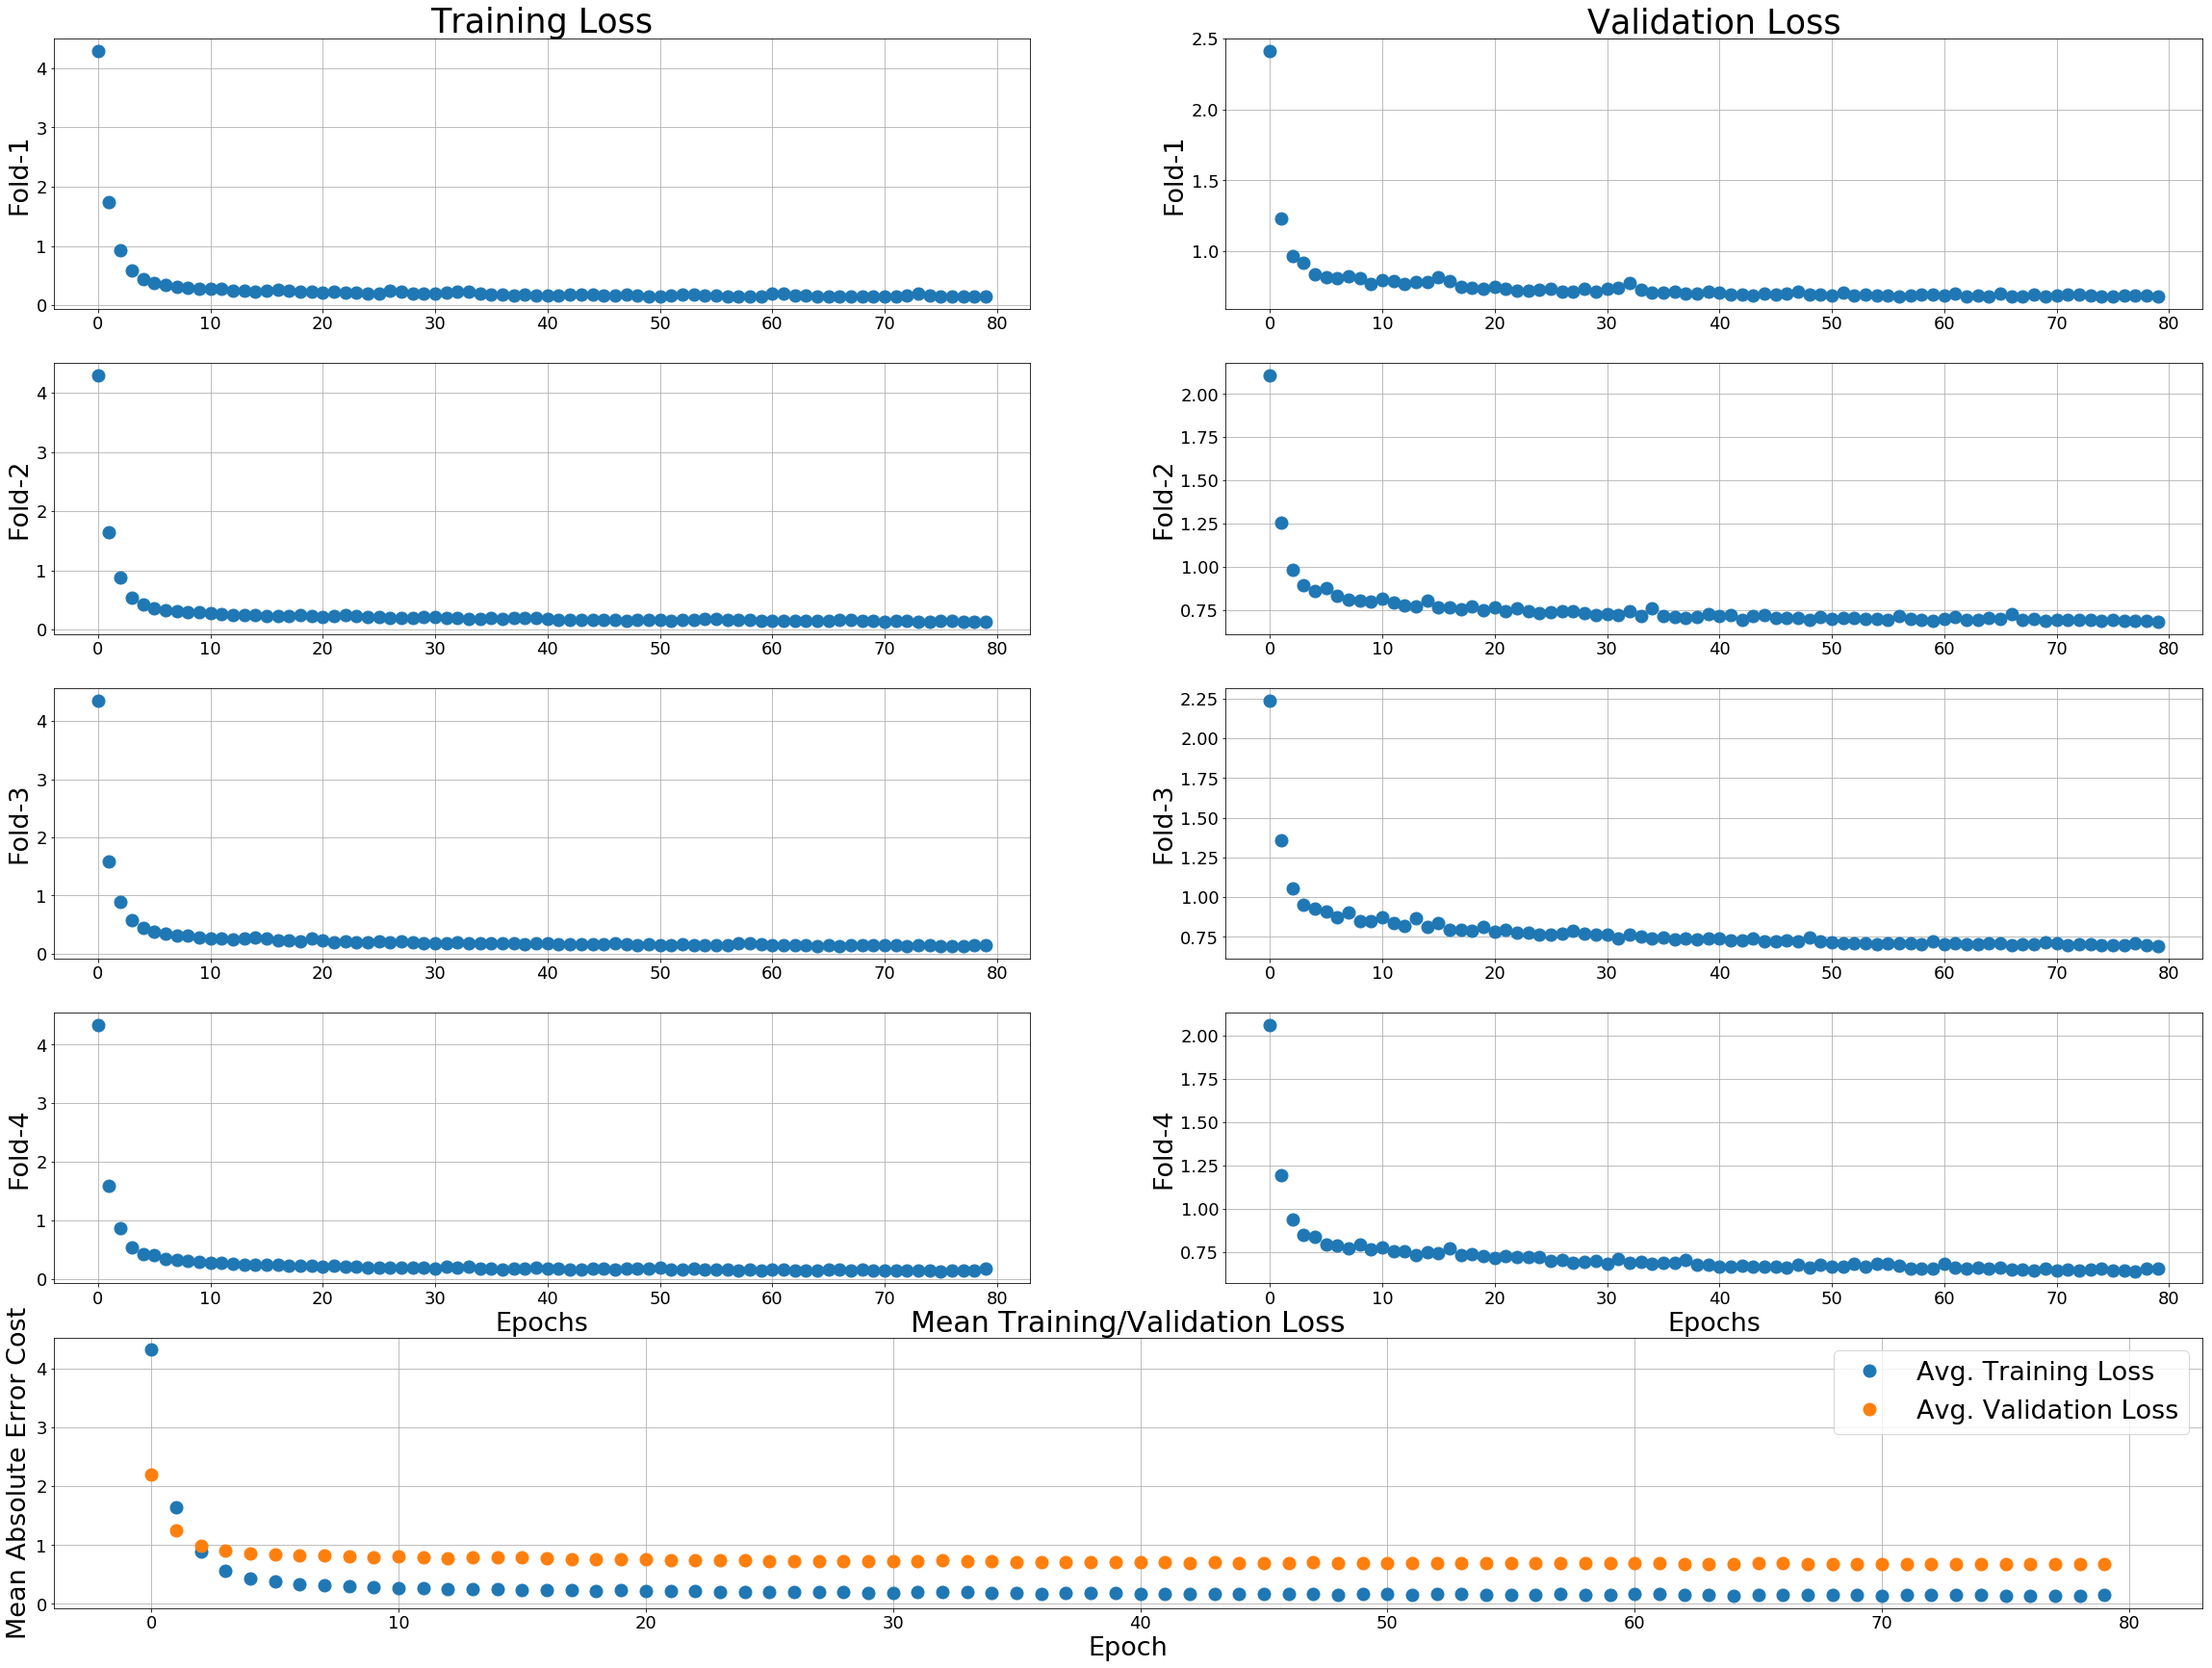

In [24]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [25]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[76 75 79 74 77 67 78 70 73 62 71 72 68 69 64 63 58 66 57 59 65 55 53 54 50
 60 56 52 61 42 51 45 46 48 49 44 41 43 47 40 38 36 37 39 35 34 33 29 30 31
 26 25 28 27 24 23 32 22 21 20 17 19 18 12 16 14 13 15 11  9  8 10  6  7  5
  4  3  2  1  0]

Therefore, Epoch:76 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we cast only 1 of our crew members per movie. In other words, we create 1 movie for every director/producer in our "distinctCrew" array, and in each movie we only cast the corresponding cast member.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view who the "top choices" would be to get the highest voter rating average.

In [26]:
Xset = []
for i in range(0, len(distinctCrew)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for crewMember in Xset:
    predictions.append(float(model.predict(crewMember)))

idx = np.argsort(predictions)

In [27]:
dList = list(distinctCrew)

print('The best choices to make if you were to a cast only one "top" crew member would be:\n')
for i in idx[-1:-20:-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top" crew member would be:

Stanley Kubrick
Martin Scorsese
James Cameron
Frank Darabont
Christopher Nolan
Lasse Hallstr\u00f6m
Sergio Leone
Barry Mendel
James Mangold
Frank Capra
David Heyman
Steven Spielberg
Alfred Hitchcock
Joe Wright
Kevin Feige
Frank Miller
Albert S. Ruddy
David Lynch
Lorne Orleans


Given the state of the film industry today, the names that this model was able extrapolate are of various directors/producers who have worked on a lot of critically and commercially successful films, such as Stanley Kubrick, Martin Scorsese, James Cameron, Christopher Nolan, etc.

# REPEAT NOW: Create Rating Regression Model Based Only On Genres

In [28]:
X = createFeatures('genres')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [29]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 0s - loss: 5.3526 - val_loss: 1.4705
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 0.9558 - val_loss: 0.6794
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 0.6395 - val_loss: 0.6206
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 0.6080 - val_loss: 0.5989
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 0.5934 - val_loss: 0.5812
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 0.5737 - val_loss: 0.5787
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 0.5694 - val_loss: 0.5960
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.5673 - val_loss: 0.5726
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.5640 - val_loss: 0.5710
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.5690 - val_loss: 0.5724
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.5740 - val_loss: 0.5647
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.5705 - val_loss: 0.5647
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.5685 - val_loss: 0.5836
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.5655 - val_loss: 0.5693
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.5622 - val_loss: 0.5631
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.5636 - val_loss: 0.5573
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.5629 - val_loss: 0.5551
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.5684 - val_loss: 0.5780
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.5691 - val_loss: 0.5688
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.5646 - val_loss: 0.5556
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.5677

1727/1727 [==============================] - 0s - loss: 0.5645 - val_loss: 0.6063
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.5573 - val_loss: 0.5906
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.5525 - val_loss: 0.5831
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.5509 - val_loss: 0.6000
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.5704 - val_loss: 0.5856
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.5530 - val_loss: 0.5945
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.5546 - val_loss: 0.5823
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.5526 - val_loss: 0.5831
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.5471 - val_loss: 0.5916
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.5549 - val_loss: 0.5970
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.54

1727/1727 [==============================] - 0s - loss: 0.5626 - val_loss: 0.5683
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.5677 - val_loss: 0.6019
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.5633 - val_loss: 0.5626
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.5576 - val_loss: 0.5649
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.5705 - val_loss: 0.5729
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.5649 - val_loss: 0.5755
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.5698 - val_loss: 0.5657
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.5668 - val_loss: 0.5568
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.5716 - val_loss: 0.6027
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.5636 - val_loss: 0.5865
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.55

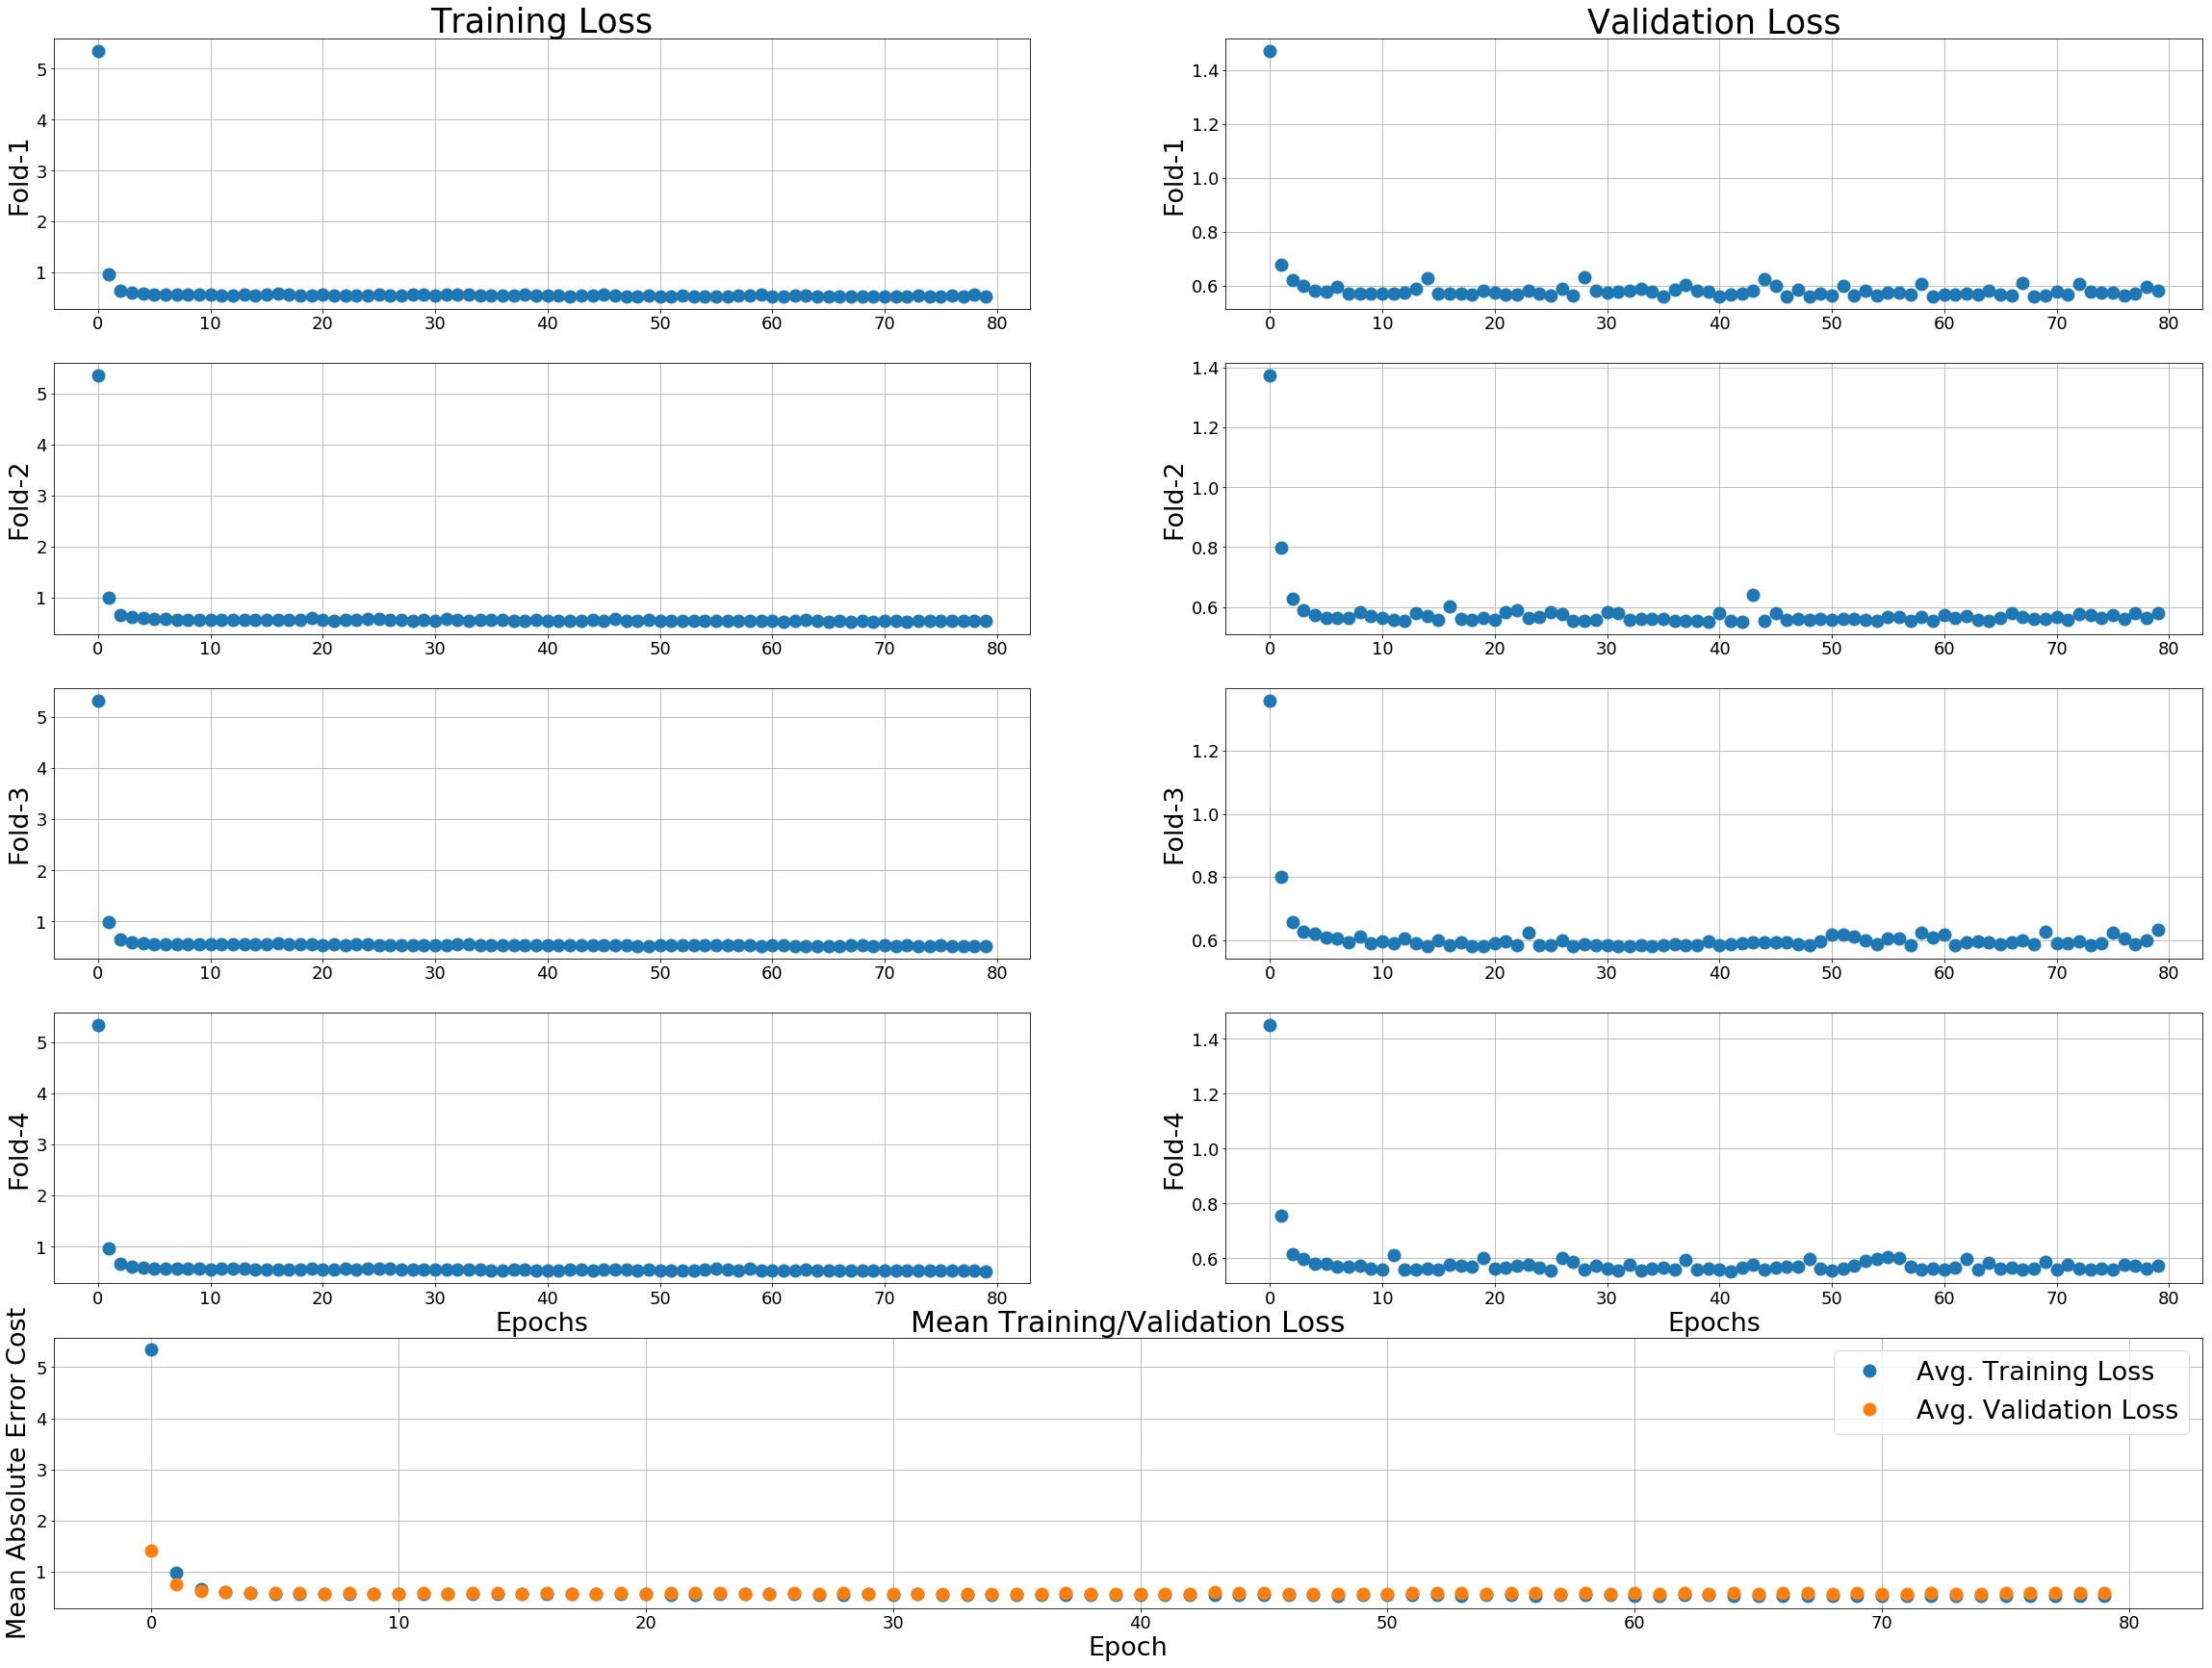

In [30]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [31]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[41 68 35 18 57 46 38 63 65 61 34 20 36 42 40 59 24 39 15 49 27 25 33 74 71
 10 12 29  9 73 31 70 32 50 17  7 48 54 47 30 77 76 66 52 22 64 21 13 60 78
 53 11 19 62 44 75 16 28  5 67 37  6 45 69  8 14 51 72 23 56 55  4 58 79 26
 43  3  2  1  0]

Therefore, Epoch:41 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we only have 1 of these genres per movie. In other words, we create 1 movie for every genre in our "distinctGenres" array.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view what the "top choices" would be to get the highest voter rating average.

In [32]:
Xset = []
for i in range(0, len(distinctGenres)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for genre in Xset:
    predictions.append(float(model.predict(genre)))

idx = np.argsort(predictions)

In [33]:
dList = list(distinctGenres)

print('The best choices to make if you were to a cast only one top genre would be:\n')
for i in idx[-1::-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one top genre would be:

War
Animation
Music
History
Mystery
Drama
Western
Crime
Romance
Fantasy
Documentary
Science Fiction
Family
Adventure
Action
Thriller
Horror
Comedy
TV Movie


Given the state of the film industry today, the order of genres that this model was able extrapolate corresponds to the critical and commercial success of our times today. Star Wars for example, contains the top 4 genres and can fit under the genres of:
- Mystery
- Romance
- Animation
- War
- Drama
- Fantasy
- and more.

# REPEAT NOW: Create Rating Regression Model Based Only On Production Companies

In [34]:
X = createFeatures('prod')
Xnorm = normalize(X, axis = 0, norm = 'l2')

In [35]:
num_epochs = 80

# K*Epoch array for storing training/validation loss history for each random fold
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    model = Sequential() # feed-forward network instantiation
    
    # 1st fully-connected dense layer (input data encounters this)
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu', input_dim=X.shape[1]))
    
    model.add(Dense(units=256, kernel_initializer= initialWeights, activation = 'relu')) # 2nd fully-connected layer
    model.add(Dense(units=128, kernel_initializer= initialWeights, activation = 'relu')) # 3rd .. .. .. .. ..
    
    # Final fully-connected layer ("y-hat")
    model.add(Dense(units=1, kernel_initializer= initialWeights, activation = 'relu'))
    
    # loss function and optimization technique specification for model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    # loss-history callback instantiation
    history = LossHistory()
    
    # begin training
    model.fit(Xnorm[train], 
              y[train], 
              validation_data = (Xnorm[test],y[test]), 
              epochs=num_epochs, 
              batch_size=64, 
              verbose=1, 
              callbacks = [history]
             )
    
    # append current training and validation loss history for current fold
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 0s - loss: 4.5763 - val_loss: 2.1874
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 1.6837 - val_loss: 1.1511
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 0.8198 - val_loss: 0.8238
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 0.5360 - val_loss: 0.7917
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 0.4426 - val_loss: 0.7378
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 0.3951 - val_loss: 0.7343
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 0.3782 - val_loss: 0.8011
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3795 - val_loss: 0.7387
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.3615 - val_loss: 0.7167
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.3435 - val_loss: 0.7640
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 0.3708 - val_loss: 0.7829
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 0.3650 - val_loss: 0.8423
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 0.3490 - val_loss: 0.7911
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 0.3223 - val_loss: 0.8321
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.3220 - val_loss: 0.7959
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.3001 - val_loss: 0.7981
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.3043 - val_loss: 0.7822
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.3250 - val_loss: 0.7943
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.3169 - val_loss: 0.8053
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.3157 - val_loss: 0.8137
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.3094

1727/1727 [==============================] - 0s - loss: 0.3153 - val_loss: 0.7587
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.3042 - val_loss: 0.7785
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.3028 - val_loss: 0.7662
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.3076 - val_loss: 0.7890
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.2941 - val_loss: 0.7574
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.2874 - val_loss: 0.7608
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.2807 - val_loss: 0.7535
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2841 - val_loss: 0.7814
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.3033 - val_loss: 0.7500
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2943 - val_loss: 0.7335
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.29

1727/1727 [==============================] - 0s - loss: 0.2844 - val_loss: 0.7452
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.2857 - val_loss: 0.7447
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.2897 - val_loss: 0.7535
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.2938 - val_loss: 0.7445
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.2846 - val_loss: 0.7381
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.2770 - val_loss: 0.7272
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.2828 - val_loss: 0.7271
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.2771 - val_loss: 0.7421
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.2673 - val_loss: 0.7320
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.2712 - val_loss: 0.7321
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.28

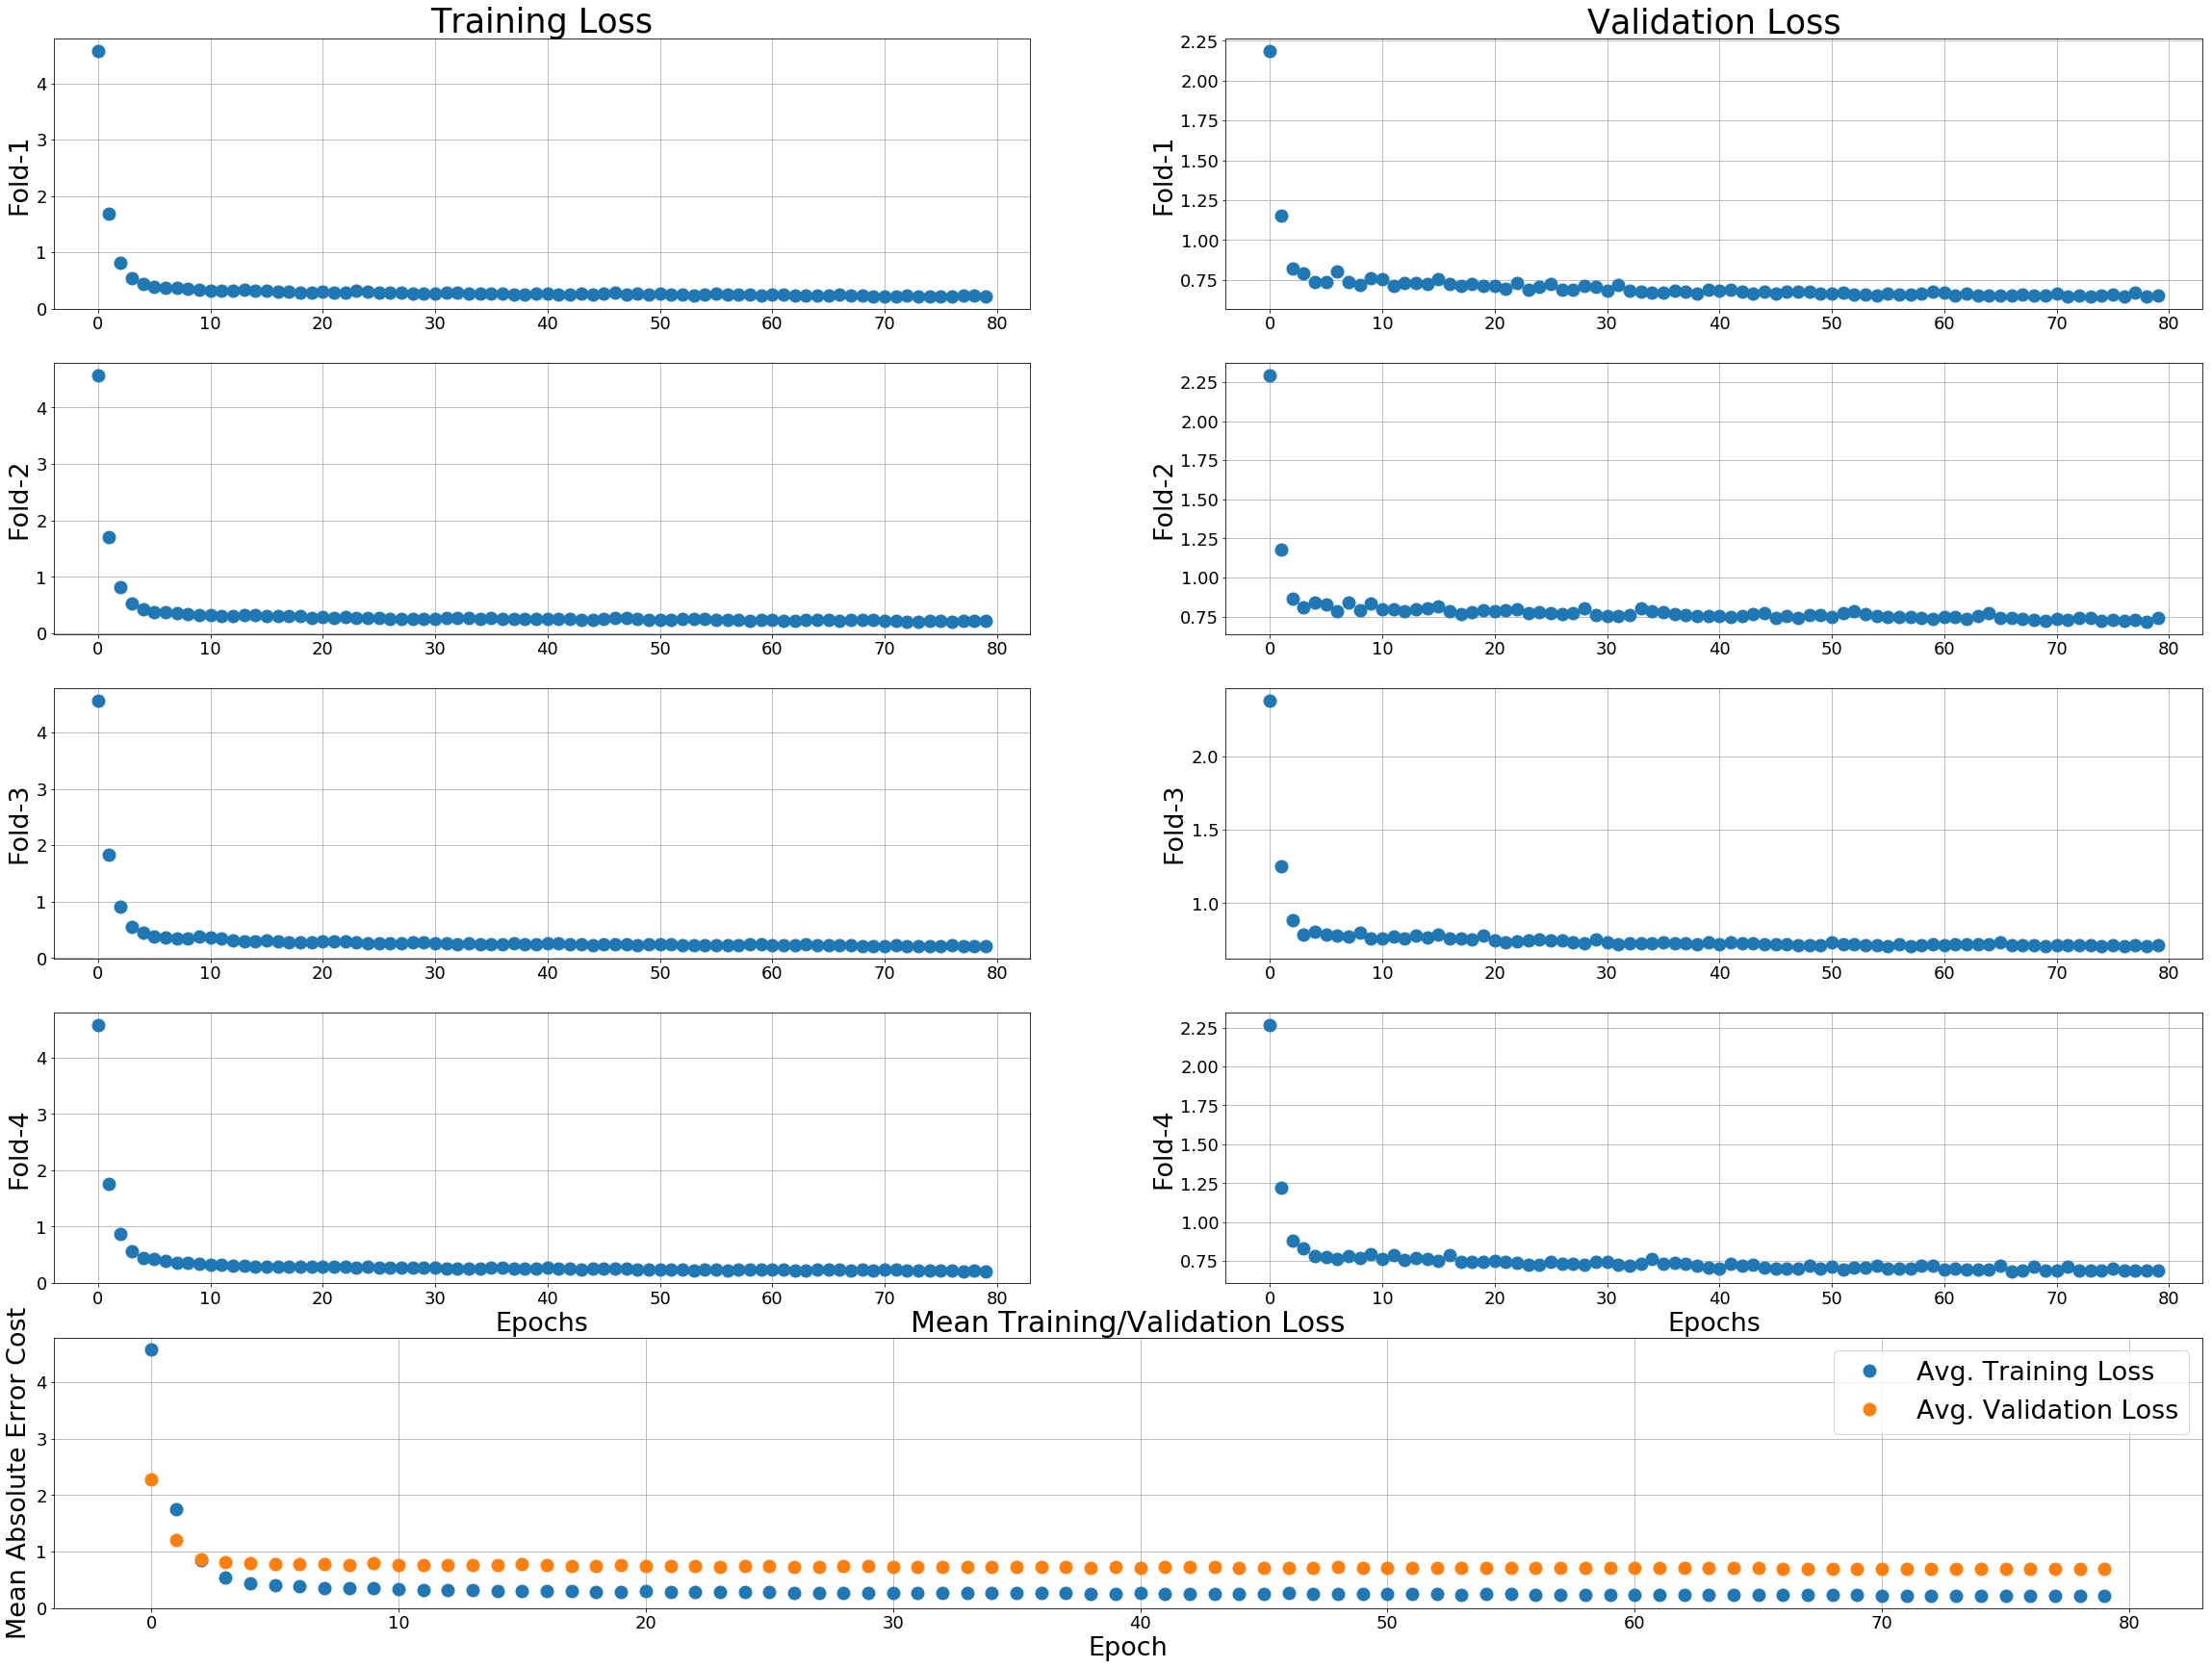

In [36]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [37]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[78 76 69 74 73 66 79 67 75 72 77 71 70 68 57 55 62 61 63 56 60 45 58 64 47
 49 54 65 53 46 50 38 51 59 40 52 44 43 48 42 39 32 37 41 30 35 36 27 31 23
 26 34 33 21 24 29 28 25 17 18 20 22 12 19 16 14 10 13  8 11 15  5  6  7  9
  4  3  2  1  0]

Therefore, Epoch:78 would be a good place to stop training this model.


### But Does the Model Really Work?

To test this question, artificial data was created in which we only have 1 of these production companies per movie. In other words, we create 1 movie for every production company in our "distinctProd" array.

Using this array of data and a trained model, we can apply these artifical movies to our regression model and predict the ratings for these fake movies. From these fake movies we can sort their ratings from greatest to least and view what the "top choices" would be to get the highest voter rating average.

In [38]:
Xset = []
for i in range(0, len(distinctProd)):
    Xcurr = np.zeros((1,X.shape[1]))
    Xcurr[0,i] = 1
    Xset.append(Xcurr)
    

predictions = []
for prod in Xset:
    predictions.append(float(model.predict(prod)))

idx = np.argsort(predictions)

In [39]:
dList = list(distinctProd)

print('The best choices to make if you were to a cast only one "top" production company would be:\n')
for i in idx[-1::-1]:
    print(list(dList)[i])

The best choices to make if you were to a cast only one "top" production company would be:

Warner Bros.
Syncopy
WingNut Films
Studio Ghibli
The Weinstein Company
United Artists
Twentieth Century Fox Film Corporation
Constantin Film Produktion
Winkler Films
Pixar Animation Studios
Sunswept Entertainment
Lucasfilm
Toho Company
Scion Films
TriStar Pictures
Warner Bros. Animation
Cloud Eight Films
Castle Rock Entertainment
Kurtzman/Orci
Studio Canal
Paramount Vantage
American Zoetrope
Selznick International Pictures
Temple Hill Entertainment
40 Acres & A Mule Filmworks
One Race Productions
Mr. Mudd Production
U-Drive Productions
Barry Mendel Productions
Jersey Films
Blue Sky Studios
Heyday Films
Blue Parrot Productions
Riche-Ludwig Productions
Miramax Films
X-Filme Creative Pool
Horizon Pictures (II)
Paramount Pictures
GK Films
Likely Story
American Empirical Pictures
Flower Films (II)
Jinks/Cohen Company
Alfran Productions
Walt Disney Feature Animation
Groucho II Film Partnership
Mutual 

Solomon/Hackett Productions
Patrick Aiello Productions
Arlington Road Productions Corporation
Cinema Line Film Corporation
Strange Matter Films
Atmosphere Entertainment MM
Hostel LLC
Instituto de la Cinematograf\u00eda y de las Artes Audiovisuales (ICAA)
Mainichi Broadcasting System (MBS)
Transworld Pictures
Weimaraner Republic Pictures
Pacific Title and Art Studio
China Film Co.
Jouer Limited
Scott Rudin Productions
Internationale Filmproduktion Blackbird Dritte
Saga Film
UGC PH
Golan-Globus Productions
TF 1 Film Productions
Constantin Film Ltd.
Salter Street Films International
SVT Drama
Disney
Lieutenant Productions
Blackfriars Bridge Films
Fuqua Films
RatPac Entertainment
Mindhunters Productie BV
Code Red Productions
thefyzz
Braveworld Productions
Disney Channel
Universal Pictures do Brasil
Euforia Film
Electric Shepherd Productions
Italian Tax Credit
Scholastic Entertainment
Grove Hill Productions
The Collective Studios
Granada Film Productions
Frontier Pictures
Ascension Producti

Riddick Canada Productions
The Jacobson Company
Mandalay Pictures
Jeepers Creepers II
Mars Production Pty. Ltd.
Dentsu Inc.
Largo Entertainment
Kasdan Pictures
Columbus 81 Productions
Worldview Entertainment
Cantharus Productions
Grosvenor Park Media Ltd.
Frantic Films
Sony Pictures Releasing
Reserve Room
Open City Films
Silver Reel
Walden Media
Hyde Park Films
Nanny McPhee Productions
Irwin Allen Productions
Hydraulx
October Pictures
Runteldat Entertainment
Material
LightWorkers Media
21 Laps Entertainment
Broken Road Productions
Great Oaks Entertainment
Dreamworks Pictures
JVC Entertainment Networks
Wessler Entertainment
Material Pictures
AI-Film
Nickelodeon Movies
Catwoman Films
Aperture Entertainment
Eidos Interactive
Schroeder Hoffman Productions
Cobalt Media Group
Zide-Perry Productions
Baltimore Spring Creek Productions
Aversano Films
Maple Shade Films
Impact Pictures
Regency Enterprises
Storm King Productions
Section Eight Productions
Lucamar Productions
Witness Protection Film

Given the state of the film industry today, the order of production companies that this model was able extrapolate corresponds to the critical and commercial success of our times today. For example, names such as:
- Warner Bros
- Syncopy
- WingNut Films
- United Artists
- The Weinstein COmpany
- Twentieth Century Fox
- and more.

# Last And Final Interesting Thing to Attempt: 
## Create Model That Uses All of These Modalities

Time to try to add layers for each of these modalities into one combined network.

In [40]:
# create arrays for seperate modalities
Xb = createFeatures('budget')
Xca = createFeatures('cast')
Xcr = createFeatures('crew')
Xg = createFeatures('genres')
Xp = createFeatures('prod')

# normalize each modality respectively
Xb_norm = normalize(Xb, axis = 0, norm = 'l2')
Xca_norm = normalize(Xca, axis = 0, norm = 'l2')
Xcr_norm = normalize(Xcr, axis = 0, norm = 'l2')
Xg_norm = normalize(Xg, axis = 0, norm = 'l2')
Xp_norm = normalize(Xp, axis = 0, norm = 'l2')

In [41]:
from keras.layers import Input, add
from keras.layers.normalization import BatchNormalization

num_epochs = 80
cvScoresHistory = []

for k, (train, test) in enumerate(kfold.split(Xnorm, y)):
    
    # budget branch
    budgetInput = Input(shape = (Xb.shape[1],))
    budgetBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(budgetInput)
    budgetBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(budgetBranch)
    budgetBranch = BatchNormalization()(budgetBranch)
    
    # cast branch
    castInput = Input(shape = (Xca.shape[1],))
    castBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(castInput)
    castBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(castBranch)
    castBranch = BatchNormalization()(castBranch)
    
    # crew branch
    crewInput = Input(shape = (Xcr.shape[1],))
    crewBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(crewInput)
    crewBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(crewBranch)
    crewBranch = BatchNormalization()(crewBranch)
    
    # genre branch
    genreInput = Input(shape = (Xg.shape[1],))
    genreBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(genreInput)
    genreBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(genreBranch)
    genreBranch = BatchNormalization()(genreBranch)
    
    # production branch
    prodInput = Input(shape = (Xp.shape[1],))
    prodBranch = Dense(units = 64, kernel_initializer = initialWeights, activation='relu')(prodInput)
    prodBranch = Dense(units = 32, kernel_initializer = initialWeights, activation='relu')(prodBranch)
    prodBranch = BatchNormalization()(prodBranch)
    
    # added combine all the layers into one added network by adding an "add-layer"
    added = add([budgetBranch, castBranch, crewBranch, genreBranch, prodBranch])
    out = Dense(units = 1, kernel_initializer = initialWeights, activation='relu')(added)
    
    model = keras.models.Model(inputs = [budgetInput, castInput, crewInput, genreInput, prodInput], outputs = out)
    model.compile(loss='mean_absolute_error',optimizer = 'adam')
    
    history = LossHistory()
    model.fit(
        [Xb_norm[train], Xca_norm[train], Xcr_norm[train], Xg_norm[train], Xp_norm[train]], y[train],
        validation_data = ([Xb_norm[test], Xca_norm[test], Xcr_norm[test], Xg_norm[test], Xp_norm[test]], y[test]),
        epochs=num_epochs,
        batch_size=64,
        verbose=1,
        callbacks = [history]
    )
    
    cvScoresHistory.append(history.losses)

Train on 1726 samples, validate on 576 samples
Epoch 1/80
1726/1726 [==============================] - 1s - loss: 6.1293 - val_loss: 6.0157
Epoch 2/80
1726/1726 [==============================] - 0s - loss: 5.1348 - val_loss: 5.2026
Epoch 3/80
1726/1726 [==============================] - 0s - loss: 4.2920 - val_loss: 4.6345
Epoch 4/80
1726/1726 [==============================] - 0s - loss: 3.8179 - val_loss: 4.3503
Epoch 5/80
1726/1726 [==============================] - 0s - loss: 3.5810 - val_loss: 4.0072
Epoch 6/80
1726/1726 [==============================] - 0s - loss: 3.3731 - val_loss: 3.7149
Epoch 7/80
1726/1726 [==============================] - 0s - loss: 3.1635 - val_loss: 3.2428
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 2.7871 - val_loss: 2.4917
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 2.3232 - val_loss: 1.8139
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 1.6774 - val_loss: 0.8649
Epoch 11/80
1726/1726 

1726/1726 [==============================] - 0s - loss: 2.8883 - val_loss: 2.7565
Epoch 8/80
1726/1726 [==============================] - 0s - loss: 2.3988 - val_loss: 1.8791
Epoch 9/80
1726/1726 [==============================] - 0s - loss: 1.8241 - val_loss: 1.3385
Epoch 10/80
1726/1726 [==============================] - 0s - loss: 1.2445 - val_loss: 0.6893
Epoch 11/80
1726/1726 [==============================] - 0s - loss: 0.6771 - val_loss: 0.6327
Epoch 12/80
1726/1726 [==============================] - 0s - loss: 0.3914 - val_loss: 0.6282
Epoch 13/80
1726/1726 [==============================] - 0s - loss: 0.2813 - val_loss: 0.6275
Epoch 14/80
1726/1726 [==============================] - 0s - loss: 0.2437 - val_loss: 0.6137
Epoch 15/80
1726/1726 [==============================] - 0s - loss: 0.2424 - val_loss: 0.6169
Epoch 16/80
1726/1726 [==============================] - 0s - loss: 0.2094 - val_loss: 0.6175
Epoch 17/80
1726/1726 [==============================] - 0s - loss: 0.2004

1727/1727 [==============================] - 0s - loss: 0.2819 - val_loss: 0.6479
Epoch 14/80
1727/1727 [==============================] - 0s - loss: 0.2516 - val_loss: 0.6434
Epoch 15/80
1727/1727 [==============================] - 0s - loss: 0.2103 - val_loss: 0.6389
Epoch 16/80
1727/1727 [==============================] - 0s - loss: 0.2074 - val_loss: 0.6316
Epoch 17/80
1727/1727 [==============================] - 0s - loss: 0.1932 - val_loss: 0.6306
Epoch 18/80
1727/1727 [==============================] - 0s - loss: 0.1869 - val_loss: 0.6176
Epoch 19/80
1727/1727 [==============================] - 0s - loss: 0.1672 - val_loss: 0.6134
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.1633 - val_loss: 0.6133
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.1823 - val_loss: 0.6019
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.1623 - val_loss: 0.6021
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.16

1727/1727 [==============================] - 0s - loss: 0.1878 - val_loss: 0.5741
Epoch 20/80
1727/1727 [==============================] - 0s - loss: 0.1727 - val_loss: 0.5692
Epoch 21/80
1727/1727 [==============================] - 0s - loss: 0.1704 - val_loss: 0.5659
Epoch 22/80
1727/1727 [==============================] - 0s - loss: 0.1974 - val_loss: 0.5696
Epoch 23/80
1727/1727 [==============================] - 0s - loss: 0.1745 - val_loss: 0.5689
Epoch 24/80
1727/1727 [==============================] - 0s - loss: 0.1654 - val_loss: 0.5820
Epoch 25/80
1727/1727 [==============================] - 0s - loss: 0.1579 - val_loss: 0.5691
Epoch 26/80
1727/1727 [==============================] - 0s - loss: 0.1627 - val_loss: 0.5699
Epoch 27/80
1727/1727 [==============================] - 0s - loss: 0.1598 - val_loss: 0.5664
Epoch 28/80
1727/1727 [==============================] - 0s - loss: 0.1504 - val_loss: 0.5678
Epoch 29/80
1727/1727 [==============================] - 0s - loss: 0.14

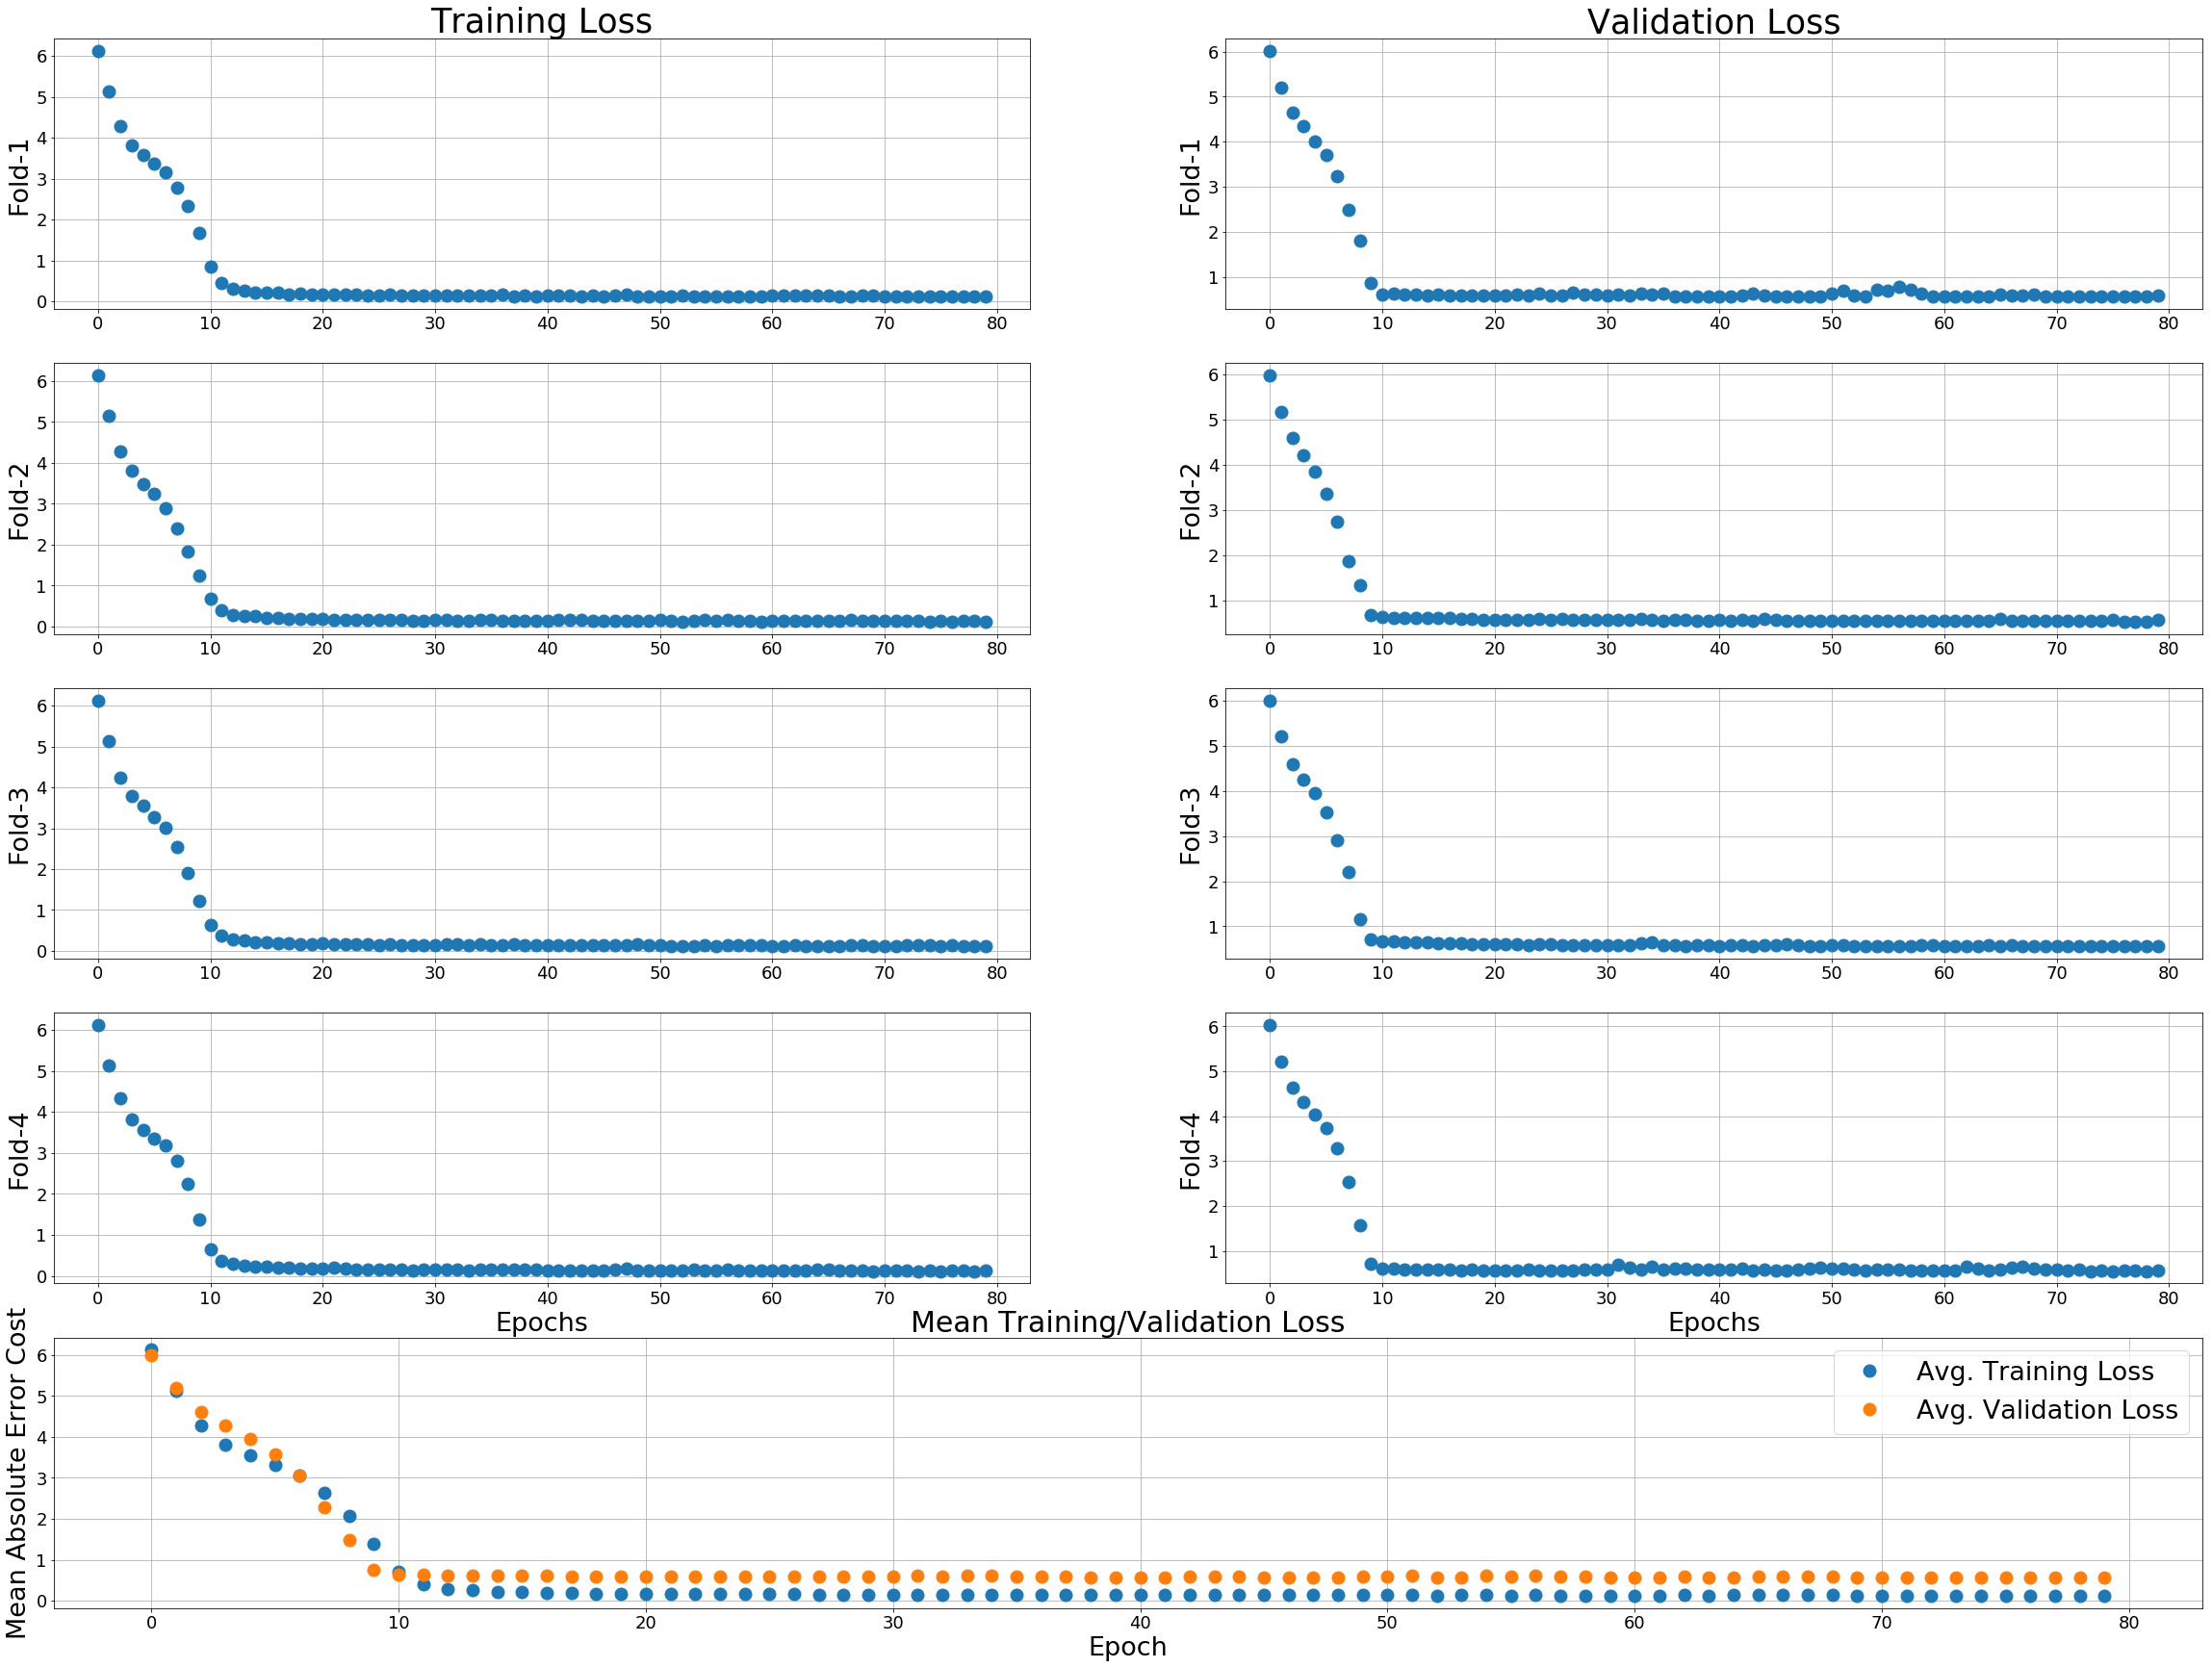

In [42]:
cvScoresHistory = np.asarray(cvScoresHistory)
meanTrainingLossHistory, meanValidationLossHistory = plotCrossValScores(cvScoresHistory, folds, num_epochs)

In [43]:
ind = np.lexsort( (meanTrainingLossHistory, meanValidationLossHistory) )
print('"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss\n')
print(ind)

print("\nTherefore, Epoch:" + str(ind[0]) + " would be a good place to stop training this model.")

"ind" is an array that contains the indices (epoch #) of sorting (least to greatest) by first the validation loss and then by the training loss

[74 78 77 73 76 71 75 53 60 61 59 64 79 70 69 72 45 40 39 63 47 48 41 38 46
 52 43 49 58 37 68 25 30 44 26 21 28 42 36 20 29 23 67 62 66 19 35 18 65 22
 27 32 17 50 55 24 57 16 33 54 15 14 51 13 12 31 34 56 11 10  9  8  7  6  5
  4  3  2  1  0]

Therefore, Epoch:74 would be a good place to stop training this model.
